# Plots for Lattice 2023 Talk

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.linalg import block_diag
import h5py
import os
import itertools
import pandas as pd
import gvar as gv
import lsqfit
from importlib import reload
from tqdm import tqdm
import datetime
from functools import reduce
from collections import namedtuple
import matplotlib.patches as mpatches

# Patrick imports
from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from fittools import *
from formattools import *
import plottools as pt

style = styles['talk']

pt.set_font()

# Will imports
import data_io_nn as io
sys.path.append('/Users/theoares/lqcd_analysis')
from lqcd_analysis import visualize as wplt
from lqcd_analysis import correlator
from lqcd_analysis import analysis
from lqcd_analysis import statistics as stats

In [2]:
def count_ndata(ydata):
    """ Counts the number of data points in ydata."""
    ndata = 0
    if hasattr(ydata, 'keys'):
        for key in ydata.keys():
            ndata += len(np.asarray(ydata[key]).flatten())
    else:
        ndata = len(np.asarray(ydata).flatten())
    return ndata


def count_nparams(params):
    """
    Counts the number of fit parameters np, being careful
    to avoid double counting of "log priors" are present.
    """
    nparams = 0
    for pname, val in params.items():
        log_pname = 'log({0})'.format(pname)
        if log_pname in params.keys():
            # Skip this parameter
            continue
        if hasattr(val, '__len__'):
            nparams += len(np.asarray(val).flatten())
        else:
            nparams += 1
    return nparams


def aic(fit):
    """
    Computes the Akaike information criterion for a given fit.
    """
    return fit.chi2 + 2.0 * count_nparams(fit.p)


def aic_model_probability(fit):
    """
    Computes the model probability associated with the Akaike information
    criterion. Generically, the raw (unnormalized) model probability is
    raw prob = exp( -0.5 * IC).
    In the present case,
    IC = AIC - 2*(Ny - Ncut)
       = chi^2 + 2*Nparams - 2*(Ny - Ncut).
    This definition uses the following pieces:
    * chi^2 is the augmented chi2,
    * Nparams is the number of parameters in the model,
    * Ny is the total number data points, and
    * Ncut is the number of points cut / dropped by choosing tmin
    The difference (Ny - Ngamma) > 0 is simply "Ndata", the total number of
    data points included in the fit. For a fixed model and fixed raw dataset,
    Nparams and Ny are constant and cancel in the normalized probabilites used
    in model averaging. So, for fixed model and fixed raw dataset,
    IC --> chi^2 + 2 Ncut.
    """
    ndata = count_ndata(fit.y)
    ic = aic(fit) - 2.0 * ndata
    # Recall the basic log-likelihood function in least-squares fitting is
    # -1/2 * chi2^2, with a factor of -1/2. So we must multiply the information
    # criterion by -1/2 in order to get the full log-likelihood.
    log_likelihood = -0.5 * ic
    return np.exp(log_likelihood)

from inspect import getfullargspec

def compute_chi2(fit, augmented=False, trust_lsqfit=False):
    """Computes the chi2 function."""
    if trust_lsqfit:
        if not augmented:
            LOGGER.warning((
                "Caution: lsqfit computes an augmented chi2 function."
                "Trusting lsqfit as specified anyway."
            ))
        return fit.chi2
    # Standard chi2, without the term involving the prior
    argspec = getfullargspec(fit.fcn)
    if (argspec.args == ['x', 'p']) or (argspec.args == ['self', 'x', 'p']):
        result = correlated_chi2(fit.fcn(fit.x, fit.p), fit.y)
    else:
        result = correlated_chi2(fit.fcn(fit.p), fit.y)
    if augmented:
        # Augmeted chi2, including the term with the prior
        result += correlated_chi2(fit.p, fit.prior)
    return result

def correlated_chi2(yfit, ydata):
    """Computes the correlated chi2 function."""
    # Get the fit values, data, and covariance matrix as dicts
    cov_dict = gv.evalcov(ydata)
    # Enforce an ordering of keys
    klist = list(ydata.keys())
    # Reserve space for arrays
    # Implementation note: flatten allows for the special case
    # of matrix-valued priors, e.g., for the transition matrix Vnn
    sizes = [len(np.asarray(ydata[key]).flatten()) for key in klist]
    total_size = sum(sizes)
    diff = np.empty(total_size)
    cov_arr = np.zeros((total_size, total_size))
    # Infer the start and end points for intervals
    ends = np.cumsum(sizes)
    starts = ends - sizes
    # Populate arrays
    for start_i, end_i, key_i in zip(starts, ends, klist):
        diff[start_i:end_i] = np.asarray(gv.mean(ydata[key_i] - yfit[key_i])).flatten()
        for start_j, end_j, key_j in zip(starts, ends, klist):
            try:
                cov_arr[start_i:end_i, start_j:end_j] =\
                    cov_dict[(key_i, key_j)]
            except ValueError:
                # Implementation note: matrix-valued priors have
                # multi-dimensional covariance matrices,
                # which must be reshaped in a 2x2 array
                cov_arr[start_i:end_i, start_j:end_j] = \
                    cov_dict[(key_i, key_j)].reshape(
                        end_i - start_i, end_j - start_j
                    )
    # The "usual" chi2 function (ydata-yfit).cov_inv.(ydata-yfit)
    try:
        result = np.dot(diff, np.linalg.solve(cov_arr, diff))
    except np.linalg.LinAlgError:
        result = np.nan
    return result

## Read and process data

For processing the data, note that $t_1$ and $t_2$ are operator source and sink and $t_\mathrm{sep}$ is a seperation time. The four-point functions are given by
\begin{equation}
    C_4(t_+, 0, v, t_-) = \sum_{\bf{x}, \bf{y}} \int \frac{d^4q}{(2\pi)^4} \frac{1}{q^2} e^{iq\cdot(x-y)} \Gamma_{\alpha \beta} \langle \mathcal O_f(t_+) J_\alpha(x) J_\beta(y) \mathcal O_i^\dagger(t_-) \rangle
\end{equation}
where $t_-$ and $t_+$ are the source and sink times, $v$ is the operator separation time $J_\mu(x) = \overline u_L(x) \gamma_\mu d_L(x)$ is the electromagnetic current, $\Gamma_{\alpha \beta} = \bar{e}_L(p_{1}) \gamma_{\alpha} \gamma_{\beta} e^{C}_{L}(p_{2})$, and $\mathcal O_i, \mathcal O_f$ are the initial and final state hadronic interpolators (for $nnpp$, $\mathcal O_i = \mathcal O_{nn}$ and $\mathcal O_f = \mathcal O_{pp}$). In the equation above, the four-vectors $x = (\mathbf{x}, 0)$ and $y = (\mathbf{y}, v)$, i.e. the two current insertions are separated by time $v$. Furthermore, we also compute two-point functions,
\begin{equation}
    C_2(t) = \langle \mathcal O_f(t) \mathcal O_i^\dagger(0) \rangle.
\end{equation}

The goal of this analysis is to extract the long-distance matrix element,
\begin{equation}
\mathcal{M}^{0\nu} \equiv \sum_{n=0}^\infty \sum_{\mathbf{x}, \mathbf{y}} \int \frac{d^3 \mathbf{q}}{(2\pi)^3} e^{i \mathbf{q}\cdot(\mathbf{x} - \mathbf{y})}
    \frac{\Gamma_{\alpha \beta} \langle f e e | J_\alpha(\mathbf{x}) | n \rangle \langle n | J_\beta(\mathbf{y}) | i \rangle}{2 E_n |\mathbf{q}| (|\mathbf{q}| + E_n - m_f)}.
\end{equation}
This matrix element is related to the four-point correlation function as the following,
\begin{equation}
    \mathcal{M}^{0\nu} = 2 m_f \int_{-\infty}^\infty dv R(v)
\end{equation}
where the ratio $R(v)$ is formed as
\begin{equation}
    R(v) = \lim_{\substack{t_+ \rightarrow \infty \\ t_- \rightarrow -\infty}} \frac{C_4(t_+, 0, v, t_-)}{C_2(t_+ - t_-)}
\end{equation}

For reading in the data:
- There are 12136 configurations.
- $C_2$ is stored with different configurations in each row, and different timeslices on each column, i.e. reads in as a $12136\times 48$ dimensional 2d array.
- $C_4$ is stored in 5 columns: $t_-$, $t_+$, $v$, $\mathrm{Re}[C_4]$, and $\mathrm{Im}[C_4]$. The source and sink times $t_-$ and $t_+$ run from 3 to 13, while the separation time $v$ runs from 6 to 16. 
- $C_4$ has 6140816 rows of data, which correspond to the 12136 configurations measured, times 506 possible values for $(t_-, t_+, v)$ to take on per each configuration. $C_4$ should be reshaped to take this into account and an extra cfg index added.

In [3]:
out_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks'

In [4]:
reload(io)

# Read and process data
base = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/processed/'
fname2 = os.path.join(base, "nnpp-2pt")
fname4 = os.path.join(base, "nnpp-4pt")
c2 = np.loadtxt(fname2)
df2 = pd.DataFrame(c2[:, :24]).reset_index().rename(columns={'index':'config'})
df4 = io.read_4pt(fname4, nblock=1)
data = io.correlate_ratio(df2, df4)
n_times = data.shape[0]        # Number of unique (t-, t+, v) tuples

In [5]:
data

,tsrc,top1,top2,tsnk,re,t-,t+,v,dt,dt+,dt-,|v|,ratio
0,0,3,3,6,0.0031990(50),-3,3,0,6,3,3,0,0.010354(14)
1,0,3,3,7,0.00023656(48),-3,4,0,7,4,3,0,0.007888(14)
2,0,3,3,8,0.000018505(49),-3,5,0,8,5,3,0,0.006512(16)
3,0,3,3,9,1.4908(56)e-06,-3,6,0,9,6,3,0,0.005619(20)
4,0,3,3,10,1.2297(70)e-07,-3,7,0,10,7,3,0,0.005047(28)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0,13,9,16,2.86(33)e-14,-9,7,4,16,3,9,4,0.00224(31)
502,0,13,10,16,3.71(48)e-14,-10,6,3,16,3,10,3,0.00290(43)
503,0,13,11,16,5.61(74)e-14,-11,5,2,16,3,11,2,0.00439(66)
504,0,13,12,16,9.6(1.2)e-14,-12,4,1,16,3,12,1,0.0075(11)


Plotting here for $|v| = 1$, note that $dt_+ = t_+ - \max(v, 0)$ and $dt_- = \min(v, 0) - t_-$. Here $t_+$ and $t_-$ are the operator separations from the sink and source, i.e. $t_+ = t_2 - t_x$, likewise for $t_-$. I think the main difference between $(t_-, t_+)$ and $(dt_-, dt_+)$ is that when you're working with $|v|$ instead of $v$, you want to use $dt$'s to keep things reasonable. 

|v| = 1


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


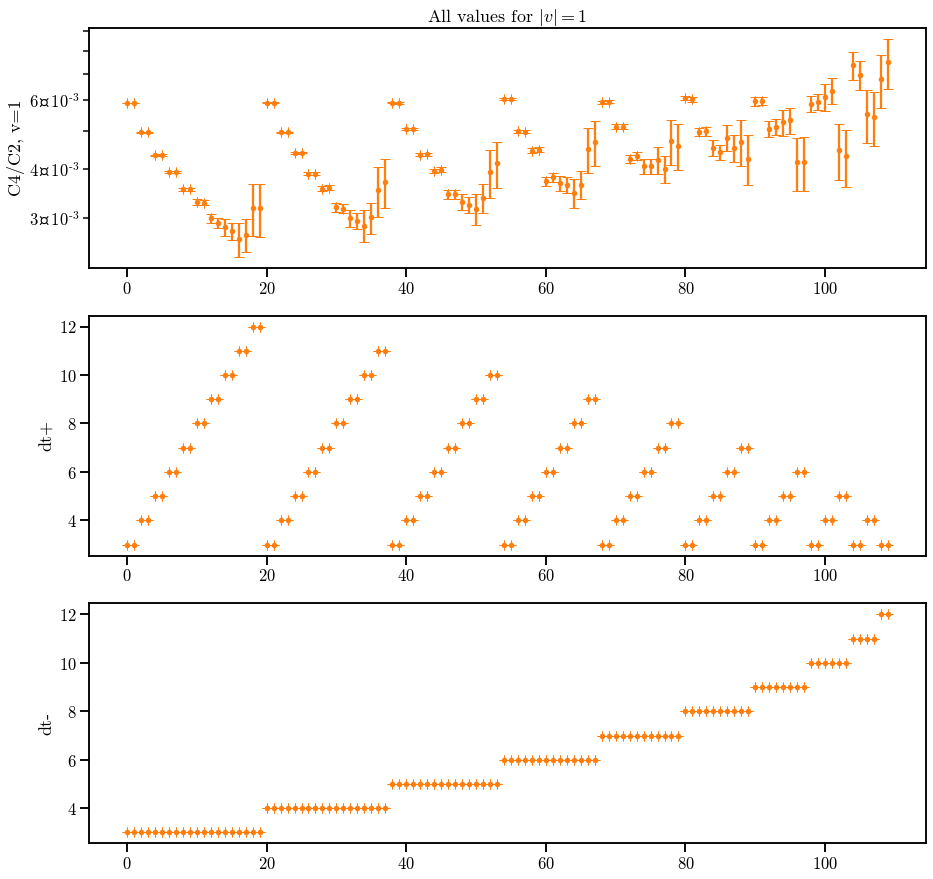

In [6]:
# recall v = operator separation, top1 - top2
with sns.plotting_context("talk"):
    # all points with |noise / signal| < 1 (for this dset, = all points)
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 1
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))
    
    # values of |v| range from -10 to +10. This iterates over all values of '|v|' with the corresponding 
    # rows in the DataFrame
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        if v != 1:
            continue
        print(f'|v| = {v}')
        subdf = subdf.sort_values(by=['dt-','dt+'])
            
        y = subdf['ratio'].values
        x = np.arange(len(y))
        offset = 0 if v > 0 else 0.5
        fig, axarr = wplt.subplots(nrows=3, figsize=(15, 15))
        ax1, ax2, ax3 = axarr
        wplt.errorbar(ax=ax1, x=x, y=y, fmt='.', capsize=5, color=color)
        wplt.errorbar(ax=ax2, x=x, y=subdf['dt+'], fmt='.', capsize=5, color=color)
        wplt.errorbar(ax=ax3, x=x, y=subdf['dt-'], fmt='.', capsize=5, color=color)

        ax1.set_ylabel("C4/C2, v="+str(v))
        ax2.set_ylabel("dt+")
        ax3.set_ylabel("dt-")
        ax1.set_yscale("log")
        
        ax1.set_title(r'All values for $|v| = 1$')

        break

In [7]:
display(data['dt+'].unique())

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

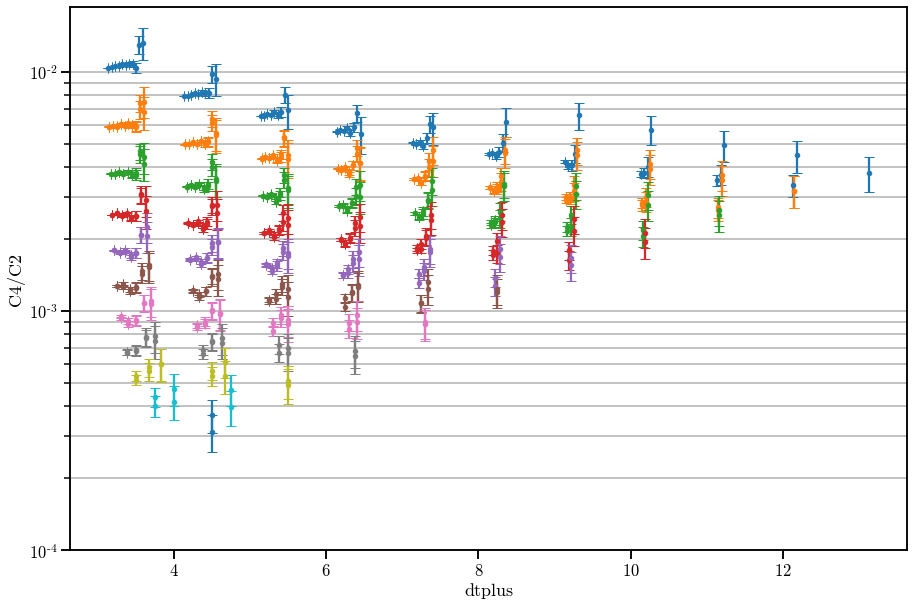

In [8]:
# here, each color = different value of |v|
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < 0.5
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, ax = wplt.subplots(nrows=1, figsize=(15, 10))
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):
        subdf = subdf.sort_values(by=['dt-','dt+'])
        #print(f'v = {v}')
        #print(subdf)
        
        # Plot: x-axis has dt+, adjusted by dt- / 2*# possible of dt- (basically just to stagger them)
        # Each fan is a single value of dt+, with various different values for dt- and for v (organized in order 
        # of increasing dt-; each vertical cross section is a given value of (dt-, dt+))
        # y-axis is ratios
        y = subdf['ratio'].values
        x = subdf['dt+'] + subdf['dt-']/(2*len(subdf['dt-'].unique()))
        offset = 0 if v > 0 else 0.5

        wplt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
    ax.set_ylabel("C4/C2")
    ax.set_xlabel("dtplus")
    ax.set_yscale("log")
    ax.grid(axis='y', which='both')
    ax.set_ylim(bottom=1e-4)

Read page 5 of the paper draft carefully, it explains a fair bit of this

In [9]:
# In Anthony's talk slides, this is called $\Delta_sink$ and it equals $t_+ - max(0, v)$: figure out WHY
data['dt+'].unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [10]:
# The colors in the next plot are given by this as well
# work it out carefully for both cases, but it's probably something like the distance from the sink to EITHER of the 
# two operators, and likewise for the source to EITHER of the two operators (i.e. distance from source to minimum of 
# the two operators)
# OK! So dt- is the magnitude of the source separation to whichever operator insertion time comes first. 
#     Likewise, dt+ is the magnitude of the sink separation to whichever operator insertion time comes last. 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[['t-', 't+', 'v', 'dt-', 'dt+']])

,t-,t+,v,dt-,dt+
0,-3,3,0,3,3
1,-3,4,0,3,4
2,-3,5,0,3,5
3,-3,6,0,3,6
4,-3,7,0,3,7
5,-3,8,0,3,8
6,-3,9,0,3,9
7,-3,10,0,3,10
8,-3,11,0,3,11
9,-3,12,0,3,12


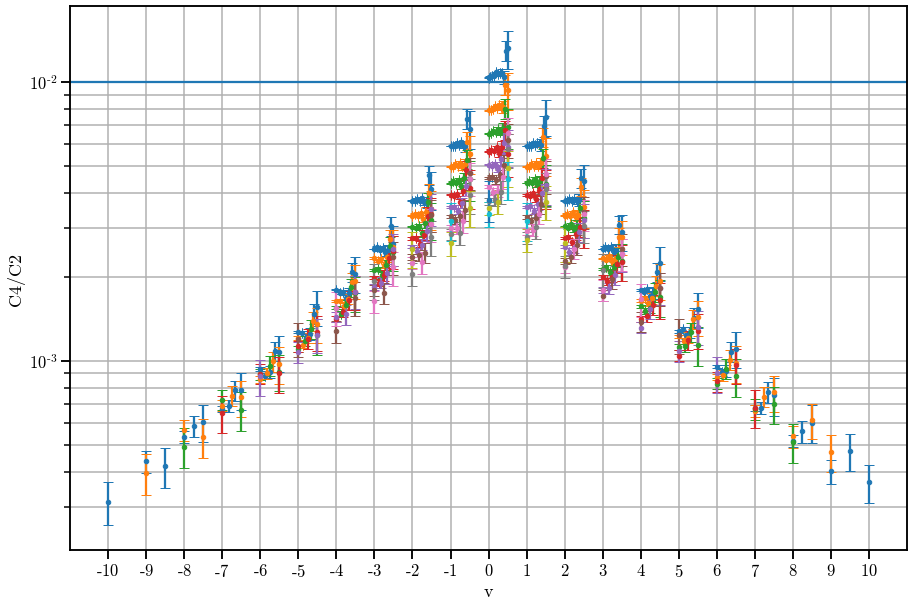

In [11]:
# Here the different colors are $dt_+$, which I think are $\Delta_sink$ in Anthony's talk slides
with sns.plotting_context("talk"):
    mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf
    colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

    fig, ax = wplt.subplots(nrows=1, figsize=(15, 10))
    for (dtp, subdf), color in zip(data[mask].groupby('dt+'), colors):
        subdf = subdf.sort_values(by=['v', 'dt-'])
            
        for v, ssubdf in subdf.groupby('v'):
            y = ssubdf['ratio'].values
            x = ssubdf['v'] + np.linspace(0, 0.5, num=len(ssubdf))
            wplt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=color)
    ax.set_ylabel("C4/C2")
    ax.set_xlabel("v")
    ax.set_yscale("log")
    ax.set_xticks(np.arange(data['v'].min(), data['v'].max()+1))
    ax.grid(axis='y', which='both')
    ax.grid(axis='x')
    ax.axhline(y=0.01)
#     ax.set_ylim(bottom=1e-4)


## Christmas Tree Plot

In [12]:
style['colwidth'] = 1000.0 / pts_per_inch
style['asp_ratio'] = 16 / 9
style['fontsize'] = 50.0
style['markersize'] = 10.0
style['tick_fontsize'] = 30.0
style['leg_fontsize'] = 25.0

style0 = copy(style)

leg_loc = (1., 1.)
colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

In [13]:
data

,tsrc,top1,top2,tsnk,re,t-,t+,v,dt,dt+,dt-,|v|,ratio
0,0,3,3,6,0.0031990(50),-3,3,0,6,3,3,0,0.010354(14)
1,0,3,3,7,0.00023656(48),-3,4,0,7,4,3,0,0.007888(14)
2,0,3,3,8,0.000018505(49),-3,5,0,8,5,3,0,0.006512(16)
3,0,3,3,9,1.4908(56)e-06,-3,6,0,9,6,3,0,0.005619(20)
4,0,3,3,10,1.2297(70)e-07,-3,7,0,10,7,3,0,0.005047(28)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0,13,9,16,2.86(33)e-14,-9,7,4,16,3,9,4,0.00224(31)
502,0,13,10,16,3.71(48)e-14,-10,6,3,16,3,10,3,0.00290(43)
503,0,13,11,16,5.61(74)e-14,-11,5,2,16,3,11,2,0.00439(66)
504,0,13,12,16,9.6(1.2)e-14,-12,4,1,16,3,12,1,0.0075(11)


Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/christmas_tree.pdf.


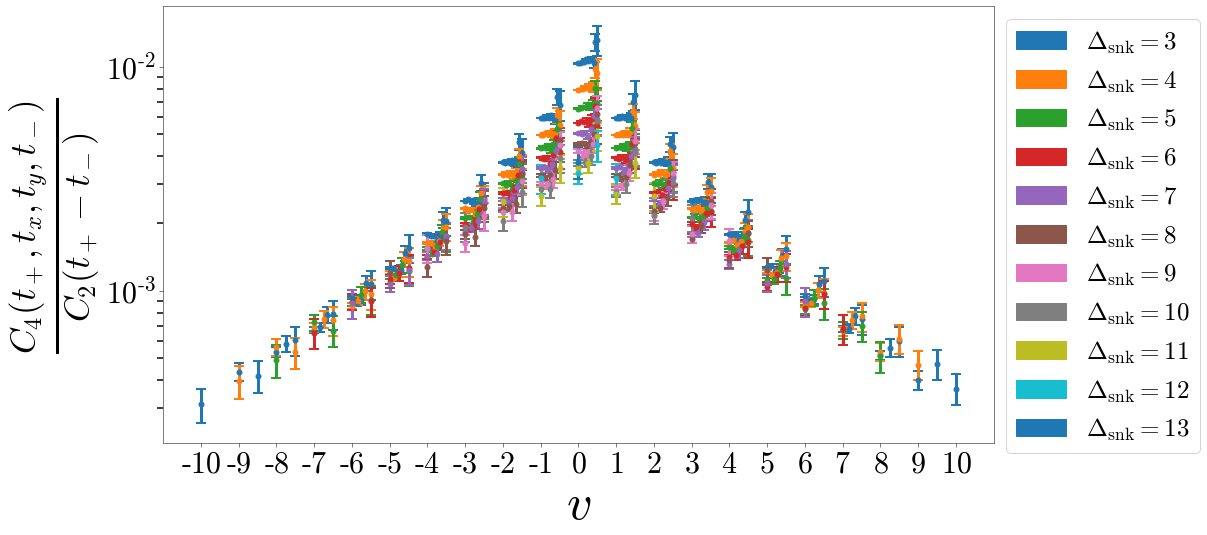

In [14]:
mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf

patches = []
fig, axes = pt.add_subplots(style = style0)
ax0 = axes[0]
for (dtp, subdf), color in zip(data[mask].groupby('dt+'), colors):
    subdf = subdf.sort_values(by=['v', 'dt-'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{snk} = ' + str(dtp) + r'$')
    )
    for v, ssubdf in subdf.groupby('v'):
        # display(ssubdf)
        y = ssubdf['ratio'].values
        x = np.array(ssubdf['v'] + np.linspace(0, 0.5, num=len(ssubdf)))
        cvs = gv.mean(y)
        stds = gv.sdev(y)
        pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style0)
ax0.set_xlabel(r'$v$')
ax0.set_ylabel(r'$\frac{C_4(t_+, t_x, t_y, t_-)}{C_2(t_+ - t_-)}$')
ax0.set_yscale('log')
ax0.set_xticks(np.arange(data['v'].min(), data['v'].max()+1))
pt.stylize_axis(ax0, style = style0)
plt.legend(handles = patches, fontsize = style0['leg_fontsize'], bbox_to_anchor = leg_loc)

path0 = f'{out_dir}/christmas_tree.pdf'
pt.save_figure(path0)
print(f'Output saved to {path0}.')

In [15]:
np.max(cvs)

0.0037792643114925107

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/christmas_tree_COLORED.pdf.


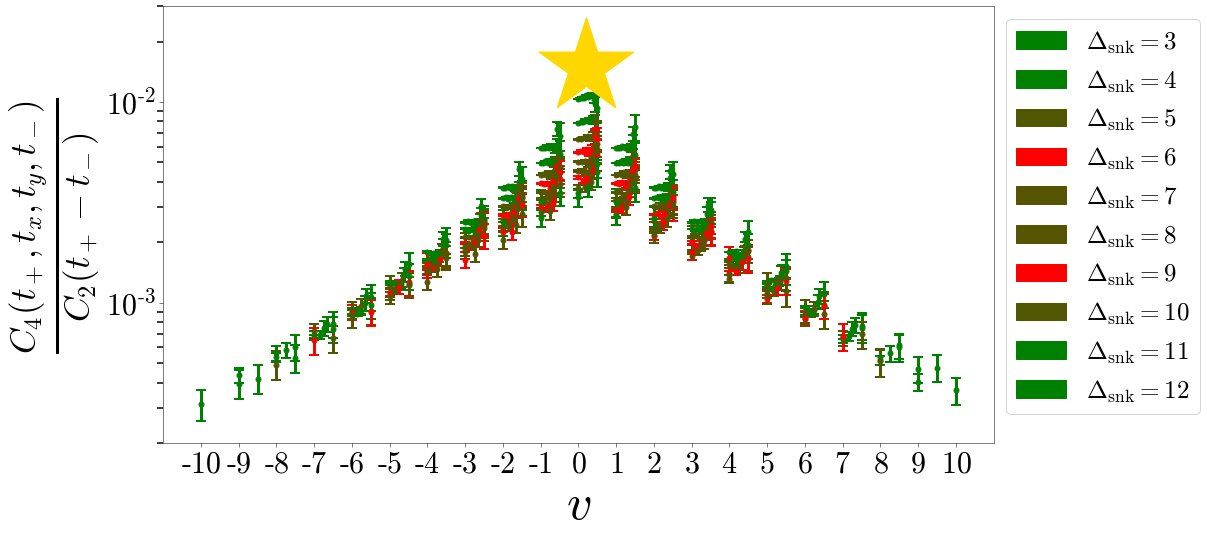

In [16]:
# cmap = LinearSegmentedColormap.from_list('GreenRedGreen', ['green', 'red', 'green'])
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('GreenGreenRedGreenRedGreenGreen', ['green', 'green', 'red', 'green', 'red', 'green', 'green'])
christmas_cols = cmap(np.linspace(0, 1, 10))

mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf

patches = []
fig, axes = pt.add_subplots(style = style0)
ax0 = axes[0]
for (dtp, subdf), color in zip(data[mask].groupby('dt+'), christmas_cols):
    subdf = subdf.sort_values(by=['v', 'dt-'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{snk} = ' + str(dtp) + r'$')
    )
    for v, ssubdf in subdf.groupby('v'):
        # display(ssubdf)
        y = ssubdf['ratio'].values
        x = np.array(ssubdf['v'] + np.linspace(0, 0.5, num=len(ssubdf)))
        cvs = gv.mean(y)
        stds = gv.sdev(y)
        pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style0)
ax0.scatter([0.2], [0.015], s = 10000, marker = '*', c = 'gold', zorder = 1000)
ax0.set_xlabel(r'$v$')
ax0.set_ylabel(r'$\frac{C_4(t_+, t_x, t_y, t_-)}{C_2(t_+ - t_-)}$')
ax0.set_yscale('log')
ax0.set_xticks(np.arange(data['v'].min(), data['v'].max()+1))
ax0.set_ylim((2e-4, 3e-2))
pt.stylize_axis(ax0, style = style0)
plt.legend(handles = patches, fontsize = style0['leg_fontsize'], bbox_to_anchor = leg_loc)

path0 = f'{out_dir}/christmas_tree_COLORED.pdf'
pt.save_figure(path0)
print(f'Output saved to {path0}.')

## Source Sink Contamination Plots

In [17]:
style1 = copy(style)
style1['colwidth'] = 600 / pts_per_inch
style1['asp_ratio'] = 1
# style1['tick_fontsize'] = 20.0
style1['markersize'] = 10.0

v_disp = 1
# mask = (data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf) & (data['v'] == v_disp)
mask = (data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf) & (data['|v|'] == v_disp)

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/src_snk_contamination.pdf.


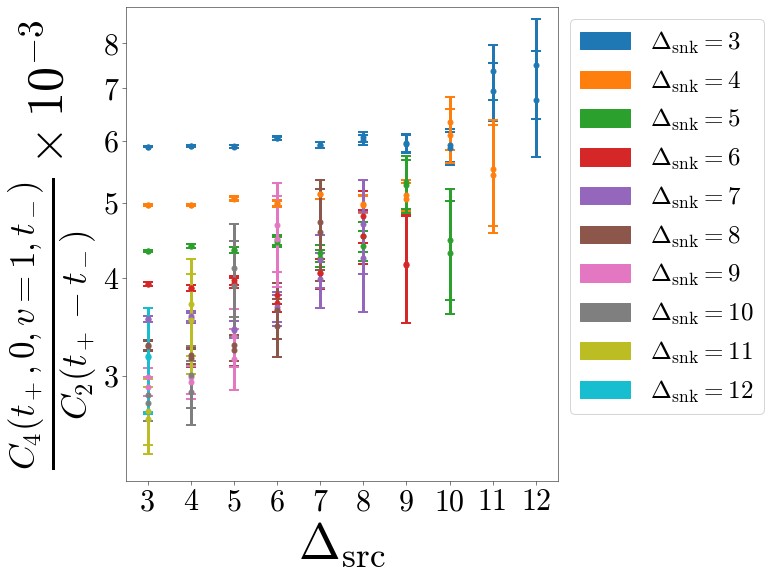

In [18]:
fig, axes = pt.add_subplots(style = style1)
ax0 = axes[0]
patches = []
for (dtp, subdf), color in zip(data[mask].groupby('dt+'), colors):
    subdf = subdf.sort_values(by=['v', 'dt-'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{snk} = ' + str(dtp) + r'$')
    )
    y = subdf['ratio'].values
    x = subdf['dt-']
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style1)
ax0.set_xlabel(r'$\Delta_{\mathrm{src}}$')
# ax0.set_ylabel(r'$\frac{C_4(t_+, 0, v = ' + str(v_disp) + r', t_-)}{C_2(t_+ - t_-)}$')
ax0.set_ylabel(r'$\frac{C_4(t_+, 0, v = ' + str(v_disp) + r', t_-)}{C_2(t_+ - t_-)}\times 10^{-3}$')
ax0.set_yscale('log')
ax0.set_yticks([n*10**(-3) for n in range(3, 9)])
# ax0.set_yticklabels([r'$' + str(n) + r'\times 10^{-3}$' for n in range(3, 9)])
ax0.set_yticklabels([str(n) for n in range(3, 9)])
ax0.set_xticks([n for n in range(3, 13)])
ax0.set_xticklabels([str(n) for n in range(3, 13)])

ax0.set_xlim((2.5, 12.5))
ax0.set_ylim((2.2e-3, 8.9e-3))

pt.stylize_axis(ax0, style = style1)
plt.legend(handles = patches, fontsize = style1['leg_fontsize'], bbox_to_anchor = leg_loc)

path1 = f'{out_dir}/src_snk_contamination.pdf'
pt.save_figure(path1)
print(f'Output saved to {path1}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/src_snk_contamination2.pdf.


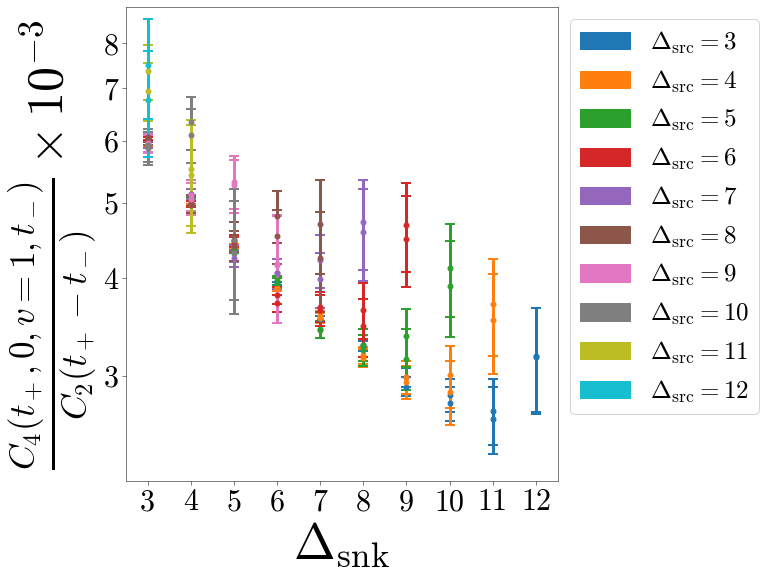

In [19]:
v_disp = 1
# mask = (data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf) & (data['v'] == v_disp)
mask = (data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf) & (data['|v|'] == v_disp)

fig, axes = pt.add_subplots(style = style1)
ax0 = axes[0]
patches = []
for (dtp, subdf), color in zip(data[mask].groupby('dt-'), colors):
    subdf = subdf.sort_values(by=['v', 'dt+'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{src} = ' + str(dtp) + r'$')
    )
    y = subdf['ratio'].values
    x = subdf['dt+']
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style1)
ax0.set_xlabel(r'$\Delta_{\mathrm{snk}}$')
ax0.set_ylabel(r'$\frac{C_4(t_+, 0, v = ' + str(v_disp) + r', t_-)}{C_2(t_+ - t_-)}\times 10^{-3}$')
ax0.set_yscale('log')
ax0.set_yticks([n*10**(-3) for n in range(3, 9)])
# ax0.set_yticklabels([r'$' + str(n) + r'\times 10^{-3}$' for n in range(3, 9)])
ax0.set_yticklabels([str(n) for n in range(3, 9)])
ax0.set_xticks([n for n in range(3, 13)])
ax0.set_xticklabels([str(n) for n in range(3, 13)])

ax0.set_xlim((2.5, 12.5))
ax0.set_ylim((2.2e-3, 8.9e-3))

pt.stylize_axis(ax0, style = style1)
plt.legend(handles = patches, fontsize = style1['leg_fontsize'], bbox_to_anchor = leg_loc)

path1 = f'{out_dir}/src_snk_contamination2.pdf'
pt.save_figure(path1)
print(f'Output saved to {path1}.')

## Local fits

In [20]:
def ratio_model(x, p):
    """
    C4/C2 = R(v) + A(v)*exp[-(tplus - v)*\Delta E]. Note that 'plateau' is the value of R(v) for each fit. 
    """
    dtp = x['dt+']
    tm = x['t-']
    return {'y': p['plateau'] + p['a+'] * np.exp(-dtp * p['dE+'])} #+ p['a-']*np.exp(-np.abs(tm)*p['dE-'])

def constant_model(x, p):
    return {'y': p['plateau']}

In [21]:
data

,tsrc,top1,top2,tsnk,re,t-,t+,v,dt,dt+,dt-,|v|,ratio
0,0,3,3,6,0.0031990(50),-3,3,0,6,3,3,0,0.010354(14)
1,0,3,3,7,0.00023656(48),-3,4,0,7,4,3,0,0.007888(14)
2,0,3,3,8,0.000018505(49),-3,5,0,8,5,3,0,0.006512(16)
3,0,3,3,9,1.4908(56)e-06,-3,6,0,9,6,3,0,0.005619(20)
4,0,3,3,10,1.2297(70)e-07,-3,7,0,10,7,3,0,0.005047(28)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0,13,9,16,2.86(33)e-14,-9,7,4,16,3,9,4,0.00224(31)
502,0,13,10,16,3.71(48)e-14,-10,6,3,16,3,10,3,0.00290(43)
503,0,13,11,16,5.61(74)e-14,-11,5,2,16,3,11,2,0.00439(66)
504,0,13,12,16,9.6(1.2)e-14,-12,4,1,16,3,12,1,0.0075(11)


In [22]:
fits_ratio = []

for dtp_cut in [1,2,3,4,5,6]:

    mask =\
        (data['ratio'].apply(analysis.n2s).apply(np.abs) < 1.5) &\
        (data['dt+'] >= dtp_cut)
    
    # Note these fits are exploiting the symmetry v --> -v, so grouping by |v|
    for (v, subdf), color in zip(data[mask].groupby('|v|'), colors):

        subdf = subdf.sort_values(by=['dt+','dt-'])
        if v <= 5:
            fcn = ratio_model
            x = {
                'dt+': subdf['dt+'].values,
                't-': subdf['t-'].values,
            }
            plateau_guess = gv.gvar(0.0035, 0.001)*np.exp(-gv.gvar(0.23, 0.05)*v)
            # lognormal priors to constrain positivity
            prior = {
                'log(plateau)': np.log(plateau_guess),
                'log(a+)': np.log(gv.gvar(0.05, 0.05)),
                'log(dE+)': np.log(gv.gvar(0.25, 0.5)),
#                 'log(a-)': np.log(gv.gvar(0.05, 0.05)),
#                 'log(dE-)': np.log(gv.gvar(0.25, 0.5)),
            }
            mode = 'ratio'
        else:
            fcn = constant_model
            x = {'dt+': subdf['dt+'].values}
            prior = {
                'plateau': gv.gvar(1e-2, 1e-2),
            }
            mode = 'constant'
        y = {'y': subdf['ratio'].values}
        fit = lsqfit.nonlinear_fit(data=(x,y), fcn=fcn, prior=prior)
        weight = aic_model_probability(fit)
        fits_ratio.append({
            'v': v,
            'fit': fit,
            'chi2': fit.chi2, 
            'chi2_aug': compute_chi2(fit, augmented=True),
            'chi2_data': compute_chi2(fit, augmented=False),
            'chi2/dof': fit.chi2/fit.dof,
            'dof': fit.dof,
            'nparam': len(fit.p),
            'Q': fit.Q,
            'weight': weight,
            'aic': -2*np.log(weight),
            'p': fit.p,
            'plateau': fit.p['plateau'],
            'a+': fit.p.get('a+', np.nan),
            'dE+': fit.p.get('dE+', np.nan),
            'dtp_cut': dtp_cut,
            'mode': mode,
        })
        
fits_ratio = pd.DataFrame(fits_ratio)

In [23]:
fits_ratio

,v,fit,chi2,chi2_aug,chi2_data,chi2/dof,dof,nparam,Q,weight,aic,p,plateau,a+,dE+,dtp_cut,mode
0,0,Least Square Fit:\n chi2/dof [dof] = 17 [66] ...,1099.642201,1099.642201,1098.685155,16.661245,66,3,3.225768e-187,3.769488e-212,973.642201,"[log(plateau), log(a+), log(dE+)]",0.004343(17),0.03069(14),0.5399(22),1,ratio
1,1,Least Square Fit:\n chi2/dof [dof] = 2 [110] ...,215.784518,215.784518,212.884888,1.961677,110,3,7.163492e-09,4.097290e-01,1.784518,"[log(plateau), log(a+), log(dE+)]",0.002869(25),0.009245(47),0.3708(40),1,ratio
2,2,Least Square Fit:\n chi2/dof [dof] = 1.2 [90]...,110.360313,110.360313,103.757887,1.226226,90,3,7.145437e-02,6.594510e+13,-63.639687,"[log(plateau), log(a+), log(dE+)]",0.001866(47),0.004071(23),0.2571(79),1,ratio
3,3,Least Square Fit:\n chi2/dof [dof] = 1.3 [72]...,90.045632,90.045632,79.525602,1.250634,72,3,7.375821e-02,2.589159e+10,-47.954368,"[log(plateau), log(a+), log(dE+)]",0.001313(86),0.002220(50),0.202(17),1,ratio
4,4,Least Square Fit:\n chi2/dof [dof] = 1.3 [56]...,71.109547,71.109547,56.259209,1.269813,56,3,8.408429e-02,3.770211e+07,-34.890453,"[log(plateau), log(a+), log(dE+)]",0.00084(18),0.00143(14),0.139(30),1,ratio
5,5,Least Square Fit:\n chi2/dof [dof] = 1.5 [42]...,62.357396,62.357396,43.741368,1.484700,42,3,2.227199e-02,2.493149e+03,-15.642604,"[log(plateau), log(a+), log(dE+)]",0.00064(21),0.00088(19),0.111(41),1,ratio
6,6,Least Square Fit:\n chi2/dof [dof] = 2.5 [30]...,75.927085,75.927085,75.102222,2.530903,30,1,7.478913e-06,1.279920e-04,17.927085,[plateau],0.000918(11),NaN,NaN,1,constant
7,7,Least Square Fit:\n chi2/dof [dof] = 0.77 [20...,15.481195,15.481195,14.611283,0.774060,20,1,7.482436e-01,7.760620e+04,-22.518805,[plateau],0.000673(14),NaN,NaN,1,constant
8,8,Least Square Fit:\n chi2/dof [dof] = 1.1 [12]...,12.829042,12.829042,11.931053,1.069087,12,1,3.815882e-01,9.805015e+01,-9.170958,[plateau],0.000524(20),NaN,NaN,1,constant
9,9,Least Square Fit:\n chi2/dof [dof] = 0.51 [6]...,3.059979,3.059979,2.142378,0.509997,6,1,8.012820e-01,3.213708e+01,-6.940021,[plateau],0.000421(31),NaN,NaN,1,constant


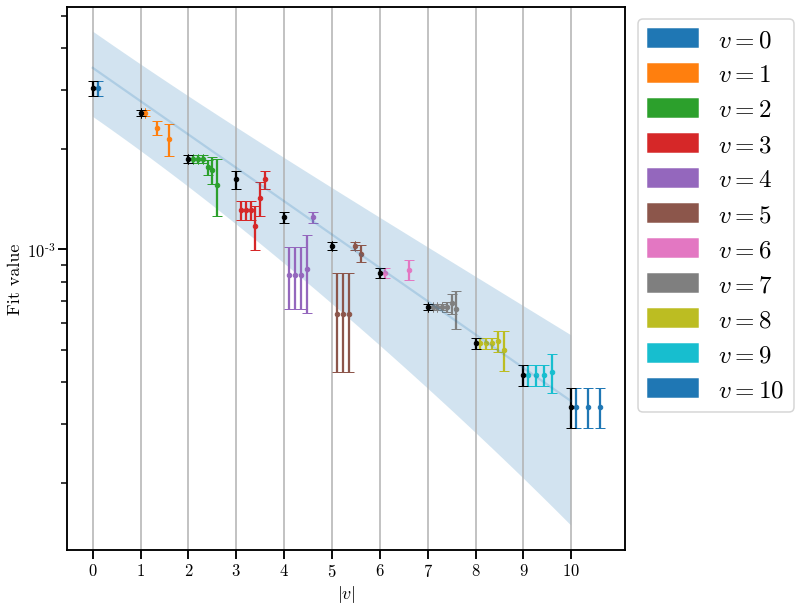

In [24]:
single_best = []

patches = []
with sns.plotting_context("talk"):
    fig, ax = wplt.subplots(1, figsize=(10, 10))
    mask = (fits_ratio['chi2/dof'] < 1.5)
    
    # Look at all fits with chi^2/dof < 1.5, grouped by |v|
    # for v, subdf in fits_ratio[mask].groupby('v'):
    for (v, subdf), col in zip(fits_ratio[mask].groupby('v'), colors):
        #print(v)
        #display(subdf)
        patches.append( 
            mpatches.Patch(color = col, label = r'$v = ' + str(v) + r'$')
        )
        x = v + np.linspace(0, 0.5, num=len(subdf))
        x = x + 0.1
        y = subdf['plateau'].values
        
        # plot accepted fits (chi^2 / dof < 1.5) at each v, offset by one another based on Delta_snk^cut (i.e. tmin)
        wplt.errorbar(ax, x, y, fmt='.', capsize=5, color = col)
        
        # for each v, get value with the best noise-to-signal 
        best = (subdf.index == subdf['plateau'].apply(analysis.n2s).idxmin())
        y = subdf[best]['plateau'].values
        wplt.errorbar(ax, [v], y, fmt='.', capsize=5, color='k')

        single_best.append({
            'plateau': y.item(),
            'v':v
        })
        
    ax.set_yscale("log")
    ax.set_xticks(range(11))
    ax.set_xlabel(r'$|v|$')
    ax.set_ylabel('Fit value')
    ax.grid(True, axis='x')

    x = np.linspace(0, 10)

    y = gv.gvar(0.0035, 0.001)*np.exp(-gv.gvar(0.23, 0.05)*x)
    wplt.errorbar(ax, x, y, bands=True, alpha=0.2)
    ax.legend(handles = patches, fontsize = style0['leg_fontsize'], bbox_to_anchor = leg_loc)
    # ax.set_ylim(1e-8)
    
single_best = pd.DataFrame(single_best)

Least Square Fit:
  chi2/dof [dof] = 3.2 [11]    Q = 0.00027    logGBF = 70.624

Parameters:
        log(a0)     -5.752 (23)      [     -7 (1000) ]  
        log(E0)     -1.490 (18)      [    -1.2 (1.0) ]  
------------------------------------------------------
             a0   0.003178 (72)      [ 0.001 (1.000) ]  
             E0     0.2253 (41)      [     0.30 (30) ]  

Fit:
      key           y[key]         f(p)[key]
--------------------------------------------
      y 0     0.00304 (15)     0.003178 (72)  
        1    0.002560 (53)     0.002537 (50)  
        2    0.001866 (47)     0.002025 (35)  ***
        3     0.00162 (10)     0.001616 (26)  
        4    0.001251 (47)     0.001290 (20)  
        5    0.001024 (30)     0.001030 (16)  
        6    0.000852 (31)     0.000822 (14)  
        7    0.000673 (14)     0.000656 (13)  *
        8    0.000524 (20)     0.000524 (12)  
        9    0.000421 (31)     0.000418 (11)  
       10    0.000337 (46)    0.0003338 (96)  

Settin

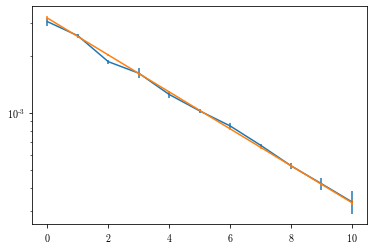

In [25]:
# Get a functional form for R(v). This is A e^{- E0 v}, which is option (3) in the paper draft
def model_reduced(x, p):
    return {'y': p['a0'] * np.exp(-x*p['E0'])}

prior = {
    'log(a0)': np.log(gv.gvar(1e-3, 1.0)),
    'log(E0)': np.log(gv.gvar(0.3, 0.3)),  
}

# single_best contains the fit data from R(v)
x = single_best['v'].values
y = {'y': single_best['plateau'].values}

fit = lsqfit.nonlinear_fit(data=(x,y), fcn=model_reduced, prior=prior)
print(fit.format(maxline=True))

yfit = fit.fcn(x, fit.p)

fig, ax = wplt.subplots(1)
wplt.errorbar(ax, x=x, y=y['y'])
wplt.errorbar(ax, x=x, y=yfit['y'])
ax.set_yscale("log")

fit_reduced = pd.DataFrame({
    'v': x,
    'ratio': yfit['y'],
})

fit_alternative = fit

## Replot sequential fit results

The plots to make here are:
1. Source-sink contamination with band for result for given $v$.
2. Source-sink contamination with band for result for given $v$ and example fit.
3. Christmas tree plot (normalized with $|v|$) with resulting $R(v)$ values and fit to $R(v)$. 

In [26]:
v_disp = 1
mask = (fits_ratio['v'] == v_disp) & (fits_ratio['chi2/dof'] < 1.5)
acc_fits = fits_ratio[mask]
# acc_fits['weight'] = acc_fits['weight'] / np.sum(acc_fits['weight'])
acc_fits['weight'] = acc_fits['weight'].apply(lambda x : x / np.sum(acc_fits['weight']))
display(acc_fits)
best_fit = acc_fits.loc[acc_fits['weight'].idxmax()]
# best_fit = acc_fits.loc[acc_fits['weight'].idxmin()]
display(best_fit)

/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_70552/636207970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_fits['weight'] = acc_fits['weight'].apply(lambda x : x / np.sum(acc_fits['weight']))


,v,fit,chi2,chi2_aug,chi2_data,chi2/dof,dof,nparam,Q,weight,aic,p,plateau,a+,dE+,dtp_cut,mode
34,1,Least Square Fit:\n chi2/dof [dof] = 1.3 [90]...,118.717187,118.717187,115.335375,1.319080,90,3,0.022962,0.732901,-55.282813,"[log(plateau), log(a+), log(dE+)]",0.002560(53),0.00815(11),0.3039(85),4,ratio
44,1,Least Square Fit:\n chi2/dof [dof] = 1.2 [72]...,84.736930,84.736930,80.681497,1.176902,72,3,0.144709,0.266971,-53.263070,"[log(plateau), log(a+), log(dE+)]",0.00231(11),0.00741(26),0.257(18),5,ratio
53,1,Least Square Fit:\n chi2/dof [dof] = 1.2 [56]...,68.027204,68.027204,63.261835,1.214771,56,3,0.130087,0.000128,-37.972796,"[log(plateau), log(a+), log(dE+)]",0.00214(23),0.00685(58),0.225(35),6,ratio


v                                                            1
fit          Least Square Fit:\n  chi2/dof [dof] = 1.3 [90]...
chi2                                                118.717187
chi2_aug                                            118.717187
chi2_data                                           115.335375
chi2/dof                                               1.31908
dof                                                         90
nparam                                                       3
Q                                                     0.022962
weight                                                0.732901
aic                                                 -55.282813
p                            [log(plateau), log(a+), log(dE+)]
plateau                                           0.002560(53)
a+                                                 0.00815(11)
dE+                                                 0.3039(85)
dtp_cut                                                

In [27]:
mu = best_fit['plateau'].mean
sigma = np.sum(acc_fits['weight'] * acc_fits['plateau']).sdev
def f_best(x):
    # Returns the best fit model
    return best_fit['plateau'] + best_fit['a+'] * np.exp(-x*best_fit['dE+'])

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/src_snk_contamination2_errband.pdf.


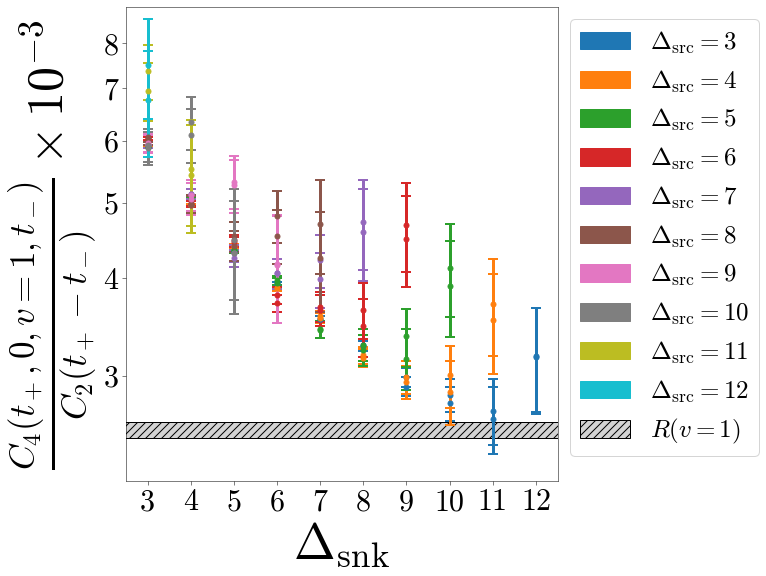

In [28]:
mask = (data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf) & (data['|v|'] == v_disp)

fig, axes = pt.add_subplots(style = style1)
ax0 = axes[0]
patches = []
for (dtp, subdf), color in zip(data[mask].groupby('dt-'), colors):
    subdf = subdf.sort_values(by=['v', 'dt+'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{src} = ' + str(dtp) + r'$')
    )
    y = subdf['ratio'].values
    x = subdf['dt+']
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style1)

xx = np.arange(2, 14)
ax0.fill_between(xx, np.full(xx.shape, mu - sigma), np.full(xx.shape, mu + sigma), color = 'lightgray', hatch = '///', edgecolor = 'k')
patches.append(mpatches.Patch(color = 'lightgray', hatch = '///', ec = 'k', label = r'$R(v = ' + str(v_disp) + r')$'))

ax0.set_xlabel(r'$\Delta_{\mathrm{snk}}$')
ax0.set_ylabel(r'$\frac{C_4(t_+, 0, v = ' + str(v_disp) + r', t_-)}{C_2(t_+ - t_-)}\times 10^{-3}$')
ax0.set_yscale('log')
ax0.set_yticks([n*10**(-3) for n in range(3, 9)])
# ax0.set_yticklabels([r'$' + str(n) + r'\times 10^{-3}$' for n in range(3, 9)])
ax0.set_yticklabels([str(n) for n in range(3, 9)])
ax0.set_xticks([n for n in range(3, 13)])
ax0.set_xticklabels([str(n) for n in range(3, 13)])
pt.stylize_axis(ax0, style = style1)
plt.legend(handles = patches, fontsize = style1['leg_fontsize'], bbox_to_anchor = leg_loc)

ax0.set_xlim((2.5, 12.5))
ax0.set_ylim((2.2e-3, 8.9e-3))

path2 = f'{out_dir}/src_snk_contamination2_errband.pdf'
pt.save_figure(path2)
print(f'Output saved to {path2}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/src_snk_contamination2_exfit.pdf.


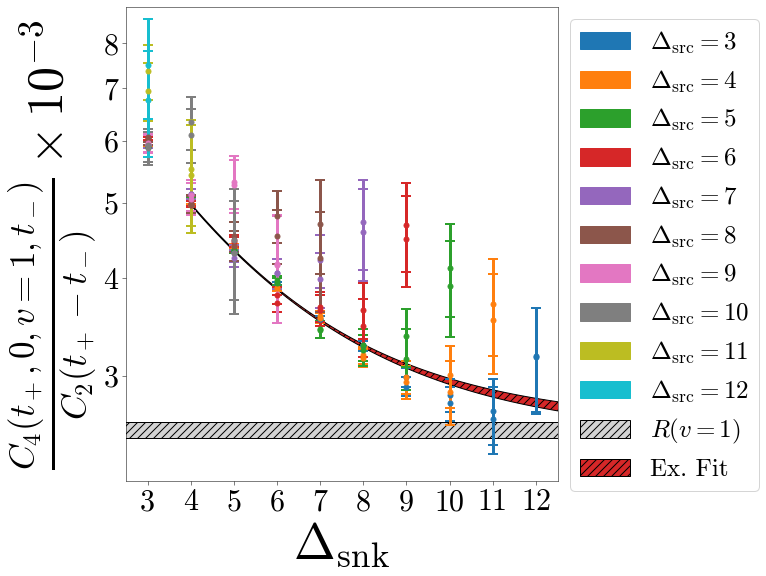

In [29]:
mask = (data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf) & (data['|v|'] == v_disp)

fig, axes = pt.add_subplots(style = style1)
ax0 = axes[0]
patches = []
for (dtp, subdf), color in zip(data[mask].groupby('dt-'), colors):
    subdf = subdf.sort_values(by=['v', 'dt+'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{src} = ' + str(dtp) + r'$')
    )
    y = subdf['ratio'].values
    x = subdf['dt+']
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style1)

xx = np.arange(2, 14)
ax0.fill_between(xx, np.full(xx.shape, mu - sigma), np.full(xx.shape, mu + sigma), color = 'lightgray', hatch = '///', edgecolor = 'k')
patches.append(mpatches.Patch(color = 'lightgray', hatch = '///', ec = 'k', label = r'$R(v = ' + str(v_disp) + r')$'))

xxx = np.linspace(best_fit['dtp_cut'], 14, 100)
yyy = f_best(xxx)
ax0.fill_between(xxx, gv.mean(yyy) - gv.sdev(yyy), gv.mean(yyy) + gv.sdev(yyy), color = sns.color_palette()[3], hatch = '///', edgecolor = 'k')
patches.append(mpatches.Patch(color = sns.color_palette()[3], hatch = '///', ec = 'k', label = 'Ex. Fit'))

ax0.set_xlabel(r'$\Delta_{\mathrm{snk}}$')
ax0.set_ylabel(r'$\frac{C_4(t_+, 0, v = ' + str(v_disp) + r', t_-)}{C_2(t_+ - t_-)}\times 10^{-3}$')
ax0.set_yscale('log')
ax0.set_yticks([n*10**(-3) for n in range(3, 9)])
# ax0.set_yticklabels([r'$' + str(n) + r'\times 10^{-3}$' for n in range(3, 9)])
ax0.set_yticklabels([str(n) for n in range(3, 9)])
ax0.set_xticks([n for n in range(3, 13)])
ax0.set_xticklabels([str(n) for n in range(3, 13)])
pt.stylize_axis(ax0, style = style1)
plt.legend(handles = patches, fontsize = style1['leg_fontsize'], bbox_to_anchor = leg_loc)

ax0.set_xlim((2.5, 12.5))
ax0.set_ylim((2.2e-3, 8.9e-3))

path2 = f'{out_dir}/src_snk_contamination2_exfit.pdf'
pt.save_figure(path2)
print(f'Output saved to {path2}.')

#### Plot $R(v)$ from the sequential fits

In [30]:
# Use single_best and plot on top of the christmas tree (normalized with |v|)
single_best

,plateau,v
0,0.00304(15),0
1,0.002560(53),1
2,0.001866(47),2
3,0.00162(10),3
4,0.001251(47),4
5,0.001024(30),5
6,0.000852(31),6
7,0.000673(14),7
8,0.000524(20),8
9,0.000421(31),9


Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/christmas_tree_seq_fit.pdf.


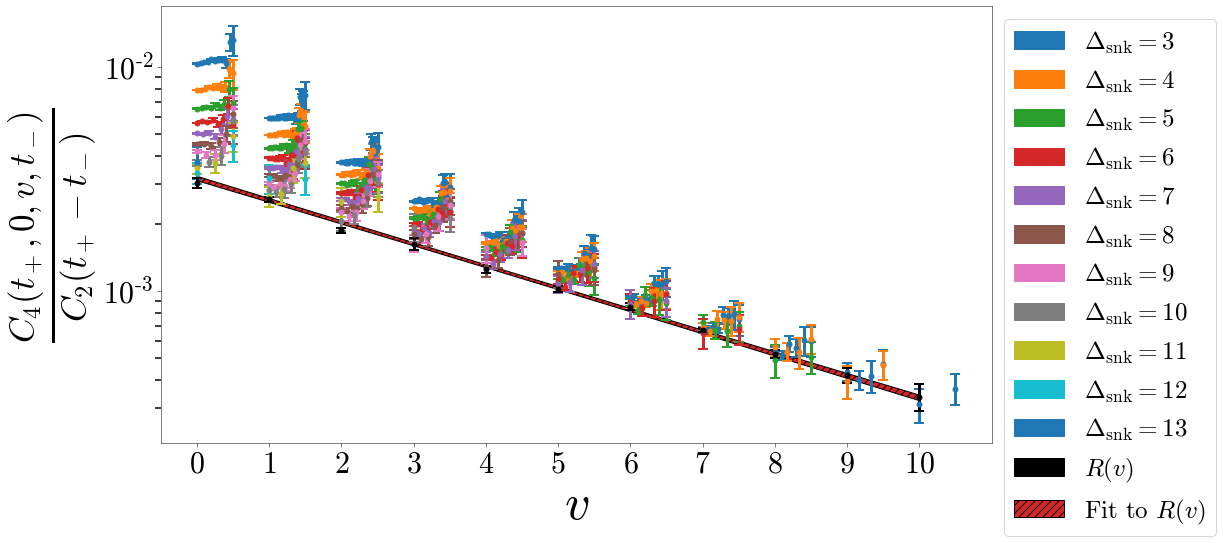

In [31]:
mask = data['ratio'].apply(analysis.n2s).apply(np.abs) < np.inf

patches = []
fig, axes = pt.add_subplots(style = style0)
ax0 = axes[0]
for (dtp, subdf), color in zip(data[mask].groupby('dt+'), colors):
    subdf = subdf.sort_values(by=['|v|', 'dt-'])
    patches.append( 
        mpatches.Patch(color = color, label = r'$\Delta_\mathrm{snk} = ' + str(dtp) + r'$')
    )
    for v, ssubdf in subdf.groupby('|v|'):
        # display(ssubdf)
        y = ssubdf['ratio'].values
        x = np.array(ssubdf['|v|'] + np.linspace(0, 0.5, num=len(ssubdf)))
        cvs = gv.mean(y)
        stds = gv.sdev(y)
        pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style0)

xx = single_best['v'].values
R = single_best['plateau'].values
R_cvs = gv.mean(R)
R_std = gv.sdev(R)
pt.errorbar_1d(xx, R_cvs, R_std, ax = ax0, col = 'k', style = style0)
patches.append(
    mpatches.Patch(color = 'k', label = r'$R(v)$')
)

xxx = np.linspace(0, 10, 100)
yplot = fit.fcn(xxx, fit.p)['y']

ax0.fill_between(xxx, gv.mean(yplot) - gv.sdev(yplot), gv.mean(yplot) + gv.sdev(yplot), color = sns.color_palette()[3], hatch = '///', edgecolor = 'k')
patches.append(mpatches.Patch(color = sns.color_palette()[3], hatch = '///', ec = 'k', label = r'Fit to $R(v)$'))

ax0.set_xlabel(r'$v$')
ax0.set_ylabel(r'$\frac{C_4(t_+, 0, v, t_-)}{C_2(t_+ - t_-)}$')
ax0.set_yscale('log')
ax0.set_xticks(np.arange(data['|v|'].min(), data['|v|'].max()+1))
pt.stylize_axis(ax0, style = style0)
plt.legend(handles = patches, fontsize = style0['leg_fontsize'], bbox_to_anchor = leg_loc)

ax0.set_xlim((-0.5, 11))
# ax0.set_ylim((0.003, 0.0034))

path0 = f'{out_dir}/christmas_tree_seq_fit.pdf'
pt.save_figure(path0)
print(f'Output saved to {path0}.')

## Global fits

Will's analysis considers three models for the Euclidean time dependence
* "Basic" $C_4/C_2 = R(v) + A(v) e^{-(t_+ - v)E_+}$
* "Full" $C_4/C_2 = R(v) + A(v) e^{-(t_+ - v)E_+} + B(v) e^{-|t_-|E_-}$
* "Extra" $C_4/C_2 = R(v) + A(v) e^{-(t_+ - v)E_+} + B(v) e^{-(t_+ - t_-)E_-}$

Currently the code does not work, I think because it was changed to log-normal priors without changing the strings in the named tuples. TODO figure it out

In [32]:
# def model_single_time(x, p, full):

#     if full:
#         # Include full time dependence
#         triplets = [(x.tm, p.am, p.Em), (x.t0, p.a0, p.E0), (x.tp, p.ap, p.Ep)]
#     else:
#         # Neglect (small) time dependence on "t-"
#         triplets = [(x.t0, p.a0, p.E0), (x.tp, p.ap, p.Ep)]    
#     result = 0
#     for (time, amp, energy) in triplets:
#         result = result + amp*np.exp(-energy*np.abs(time))
#     return result

# def global_model_full(x, p):
#     result = []
#     for (tm, t0, tp) in x:
#         t0 = np.abs(t0)
#         times = Times(tm, t0, tp)
#         params = Params(
#             p[f'am:{t0}'], # Different amplitude for each op1->op2 separation
#             p['a0'],
#             p[f'ap:{t0}'],  # Different amplitude for each op1->op2 separation
#             p['Em'],
#             p['E0'],
#             p['Ep']
#         )
#         result.append(model_single_time(x=times, p=params, full=True))
#     return {'ratio' : np.array(result)}

# def global_model(x, p):
#     result = []
#     for (tm, t0, tp) in x:
#         t0 = np.abs(t0)
#         times = Times(tm, t0, tp)
#         params = Params(
#            None,
#            p['a0'],
#            p[f'ap:{t0}'],  # Different amplitude for each op1->op2 separation
#            None,
#            p['E0'],
#            p['Ep']
#         )
#         result.append(model_single_time(x=times, p=params, full=False))


In [33]:
# Times = namedtuple('Times', ['tm', 't0', 'tp'])
# Amplitudes = namedtuple('Amplitudes', ['am', 'a0', 'ap'])
# Energies = namedtuple('Eneriges', ['Em', 'E0', 'Ep'])
# Params = namedtuple('Params', ['am', 'a0', 'ap', 'Em', 'E0', 'Ep'])

# def build_prior(data, expand=1.0, mode=None):
#     pbase = {}
#     # Amplitudes
#     pbase['log(a0)'] = np.log(gv.gvar(1e-3, 1.0*expand))
#     for t0 in data['v'].apply(np.abs).unique():    # t0 = 1, 2, 3, ..., 9
#         pbase[f'log(ap:{t0})'] = np.log(gv.gvar(1e-3, 1.0*expand))
#         if mode in ('full', 'extra'):    # set extra priors if we need it
#             pbase[f'log(am:{t0})'] = np.log(gv.gvar(1e-3, 1.0*expand))
#     # Energies
#     pbase['log(E0)'] = np.log(gv.gvar(0.3, 0.3*expand))
#     pbase['log(Ep)'] = np.log(gv.gvar(0.3, 0.3*expand))
#     if (mode == 'full'):
#         pbase['log(Em)'] = np.log(gv.gvar(1.0, 1.0*expand))
#     if (mode == 'extra'):
#         pbase['log(Em)'] = np.log(gv.gvar(0.1, 0.2*expand))        
#     return pbase

# mask =\
#     (data['dt+'] >= 4) &\
#     (data['v'] >= 1)

# # note dt = dt- + |v| + dt+
# # x is all the values of (dt, v, Delta_snk)
# x = data[mask][['dt','v','dt+']].values
# y = {'ratio': data[mask]['ratio'].values}

# prior = build_prior(data[mask], mode='full', expand=100)

# # test evaluation of model function
# # global_model(x, prior)

In [34]:
# x = data[mask][['t-','v','dt+']].values
# yfit = global_model(x, fit.p)
# tmp = pd.DataFrame(data[mask][['dt-','t-','v','|v|','dt+']])

In [35]:
# with sns.plotting_context("talk"):
    
#     mask =\
#         (data['dt+'] >= 4) &\
#         (data['v'] >= 1)
    
#     colors = sns.color_palette(n_colors=len(data['|v|'].unique()))

#     fig, axarr = wplt.subplots(ncols=2, figsize=(15, 5), sharey=False)
#     # Plot data
#     ax = axarr[0]
#     for (v, subdf) in data[mask].groupby('|v|'):
#         y = subdf['ratio'].values
#         x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
#         #offset = 0 if v > 0 else 0.5
#         wplt.errorbar(ax=ax, x=x, y=y, fmt='.', capsize=5, color=colors[v])
#     ax.set_title("Data")
        
#     # Plot fit result
#     x = data[mask][['t-','v','dt+']].values
#     yfit = global_model(x, fit.p)
#     tmp = pd.DataFrame(data[mask][['dt-','t-','v','|v|','dt+']])
#     tmp['ratio'] = yfit
    
#     ax = axarr[0]
#     for (v, subdf) in tmp.groupby('|v|'):
#         y = subdf['ratio'].values
#         x = subdf['dt+'] + subdf['dt-']/(len(subdf['dt-'].unique()))
#         #offset = 0 if v > 0 else 0.5
#         wplt.errorbar(ax=ax, x=x, y=y, fmt='o', ms=5, capsize=5,
#                      markerfacecolor='none', color='k', alpha=0.5)
    
#     # Plot residuals
#     ax = axarr[1]
#     ydata = data[mask]['ratio'].values
#     yfit = tmp['ratio'].values
#     y = (gv.mean(ydata) - gv.mean(yfit)) / gv.sdev(ydata)
#     sns.histplot(y, ax=ax, stat='probability', bins=20, label='Fit residuals')
    
#     ynormal = np.random.normal(size=len(y))
#     sns.histplot(ynormal, ax=ax, stat='probability', bins=20, label='Control')
#     ax.legend()


## Summation method

In [36]:
sumdata = []
deltas = [3,4,5,6]

tmp = {}
for tsnk, df in data.groupby('tsnk'):
    for dsrc, dsnk in itertools.product(deltas, repeat=2):
        mask =\
            (df['top1'] > dsrc) & (df['top1'] < (tsnk - dsnk)) &\
            (df['top2'] > dsrc) & (df['top2'] < (tsnk - dsnk))
        if len(df[mask]) > 0:
            if (dsrc, dsnk) not in tmp:
                tmp[(dsrc, dsnk)] = []
            tmp[(dsrc, dsnk)].append({
                'tsnk': tsnk,
                f'{dsrc}:{dsnk}': df[mask]['ratio'].sum(),
            })
            
for key in tmp:
    tmp[key] = pd.DataFrame(tmp[key])
sumdata = reduce(lambda x, y: pd.merge(x, y, on='tsnk', how='outer'), tmp.values())

In [37]:
deltas = [3,4,5,6]

tmp = []
for tsnk, df in data.groupby('tsnk'):
    for dsrc, dsnk in itertools.product(deltas, repeat=2):
        mask =\
            (df['top1'] > dsrc) & (df['top1'] < (tsnk - dsnk)) &\
            (df['top2'] > dsrc) & (df['top2'] < (tsnk - dsnk))            
        if len(df[mask]) == 0:
            continue
        tmp.append({
            'tsnk': tsnk,
            'dsrc': dsrc,
            'dsnk': dsnk,
            'ratio': df[mask]['ratio'].sum(),            
        })

# basically the same as sumdata but with a different shape
sumdata2 = pd.DataFrame(tmp)

In [38]:
sumdata

,tsnk,3:3,3:4,4:3,3:5,4:4,5:3,3:6,4:5,5:4,6:3,4:6,5:5,6:4,5:6,6:5,6:6
0,8,0.007924(19),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,0.024408(83),0.006533(23),0.007954(28),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,0.04616(23),0.02116(11),0.02492(13),0.005712(31),0.006651(35),0.008152(43),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,0.06890(56),0.03971(33),0.04557(37),0.01845(16),0.02095(18),0.02459(21),0.005005(45),0.005667(50),0.006587(57),0.008028(70),NaN,NaN,NaN,NaN,NaN,NaN
4,12,0.0955(12),0.06219(82),0.07062(92),0.03605(49),0.04068(55),0.04680(62),0.01677(24),0.01883(26),0.02154(30),0.02527(35),0.005090(75),0.005818(84),0.006791(97),NaN,NaN,NaN
5,13,0.1163(26),0.0817(19),0.0918(21),0.0537(13),0.0596(14),0.0679(16),0.03152(78),0.03454(84),0.03889(94),0.0452(11),0.01619(41),0.01793(45),0.02067(51),0.00487(13),0.00553(14),NaN
6,14,0.1466(56),0.1094(43),0.1214(47),0.0777(31),0.0860(34),0.0961(39),0.0511(22),0.0566(23),0.0631(26),0.0708(29),0.0329(14),0.0368(16),0.0411(17),0.01721(76),0.01924(84),0.00527(24)
7,15,0.195(13),0.149(10),0.168(11),0.1100(79),0.1235(87),0.1405(97),0.0775(58),0.0866(63),0.0980(70),0.1121(79),0.0564(43),0.0637(47),0.0724(52),0.0368(28),0.0417(31),0.0193(15)
8,16,0.239(29),0.195(24),0.206(25),0.159(19),0.163(20),0.172(22),0.126(15),0.129(16),0.131(17),0.138(18),0.098(12),0.098(13),0.099(13),0.0701(89),0.0684(91),0.0435(57)


In [39]:
sumdata

,tsnk,3:3,3:4,4:3,3:5,4:4,5:3,3:6,4:5,5:4,6:3,4:6,5:5,6:4,5:6,6:5,6:6
0,8,0.007924(19),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,0.024408(83),0.006533(23),0.007954(28),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,0.04616(23),0.02116(11),0.02492(13),0.005712(31),0.006651(35),0.008152(43),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,0.06890(56),0.03971(33),0.04557(37),0.01845(16),0.02095(18),0.02459(21),0.005005(45),0.005667(50),0.006587(57),0.008028(70),NaN,NaN,NaN,NaN,NaN,NaN
4,12,0.0955(12),0.06219(82),0.07062(92),0.03605(49),0.04068(55),0.04680(62),0.01677(24),0.01883(26),0.02154(30),0.02527(35),0.005090(75),0.005818(84),0.006791(97),NaN,NaN,NaN
5,13,0.1163(26),0.0817(19),0.0918(21),0.0537(13),0.0596(14),0.0679(16),0.03152(78),0.03454(84),0.03889(94),0.0452(11),0.01619(41),0.01793(45),0.02067(51),0.00487(13),0.00553(14),NaN
6,14,0.1466(56),0.1094(43),0.1214(47),0.0777(31),0.0860(34),0.0961(39),0.0511(22),0.0566(23),0.0631(26),0.0708(29),0.0329(14),0.0368(16),0.0411(17),0.01721(76),0.01924(84),0.00527(24)
7,15,0.195(13),0.149(10),0.168(11),0.1100(79),0.1235(87),0.1405(97),0.0775(58),0.0866(63),0.0980(70),0.1121(79),0.0564(43),0.0637(47),0.0724(52),0.0368(28),0.0417(31),0.0193(15)
8,16,0.239(29),0.195(24),0.206(25),0.159(19),0.163(20),0.172(22),0.126(15),0.129(16),0.131(17),0.138(18),0.098(12),0.098(13),0.099(13),0.0701(89),0.0684(91),0.0435(57)


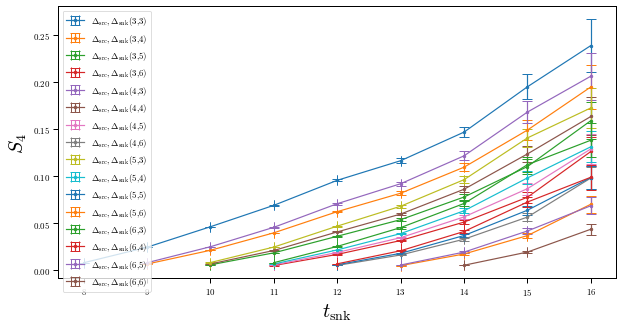

In [40]:
with sns.plotting_context("paper"):
    fig, ax = wplt.subplots(ncols=1, figsize=(10, 5))

    for dsrc, dsnk in itertools.product([3,4,5,6], repeat = 2):
        x = sumdata['tsnk'].values
        y = sumdata[f'{dsrc}:{dsnk}'].values
        wplt.errorbar(ax, x, y, fmt='.-', capsize=5,
                     label=r'$\Delta_{\rm src}, \Delta_{\rm snk}$'+f'({dsrc},{dsnk})')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # x = np.linspace(0, 16)
    # y = -0.15 + 0.018*x
    # plt.errorbar(ax, x, y, color='k')

    # x = np.linspace(0, 16)
    # y = -0.28 + 0.026*x
    # plt.errorbar(ax, x, y)

    # x = np.linspace(0, 16)
    # y = -0.32 + 0.026*x
    # plt.errorbar(ax, x, y)

    # x = np.linspace(0, 16)
    # y = -0.38 + 0.026*x
    # plt.errorbar(ax, x, y)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(r"$t_{\rm snk}$", fontsize = 20)
    ax.set_ylabel(r"$S_4$", fontsize = 20)
    ax.legend()

TODO: make sure to understand how many data points each value of  $t_{snk}$ is allowed to have (i.e. how many values of $\Delta_{src}$ and $\Delta_{snk}$ it has)

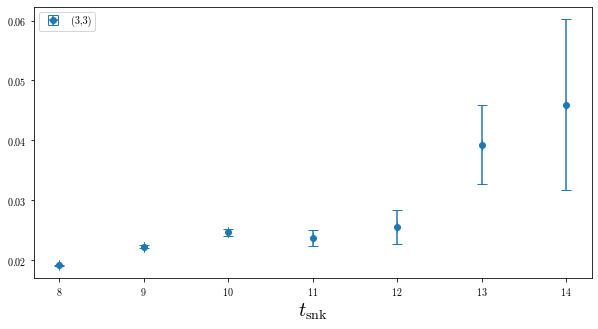

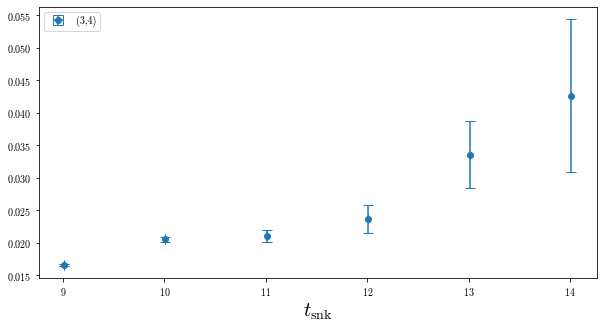

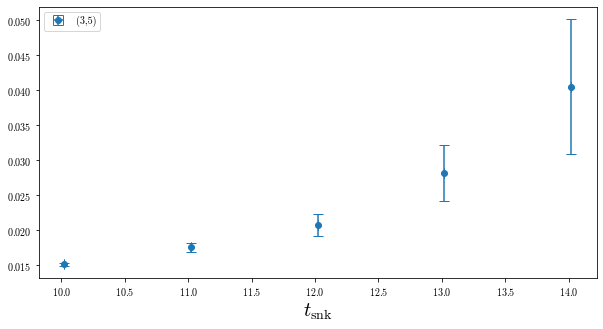

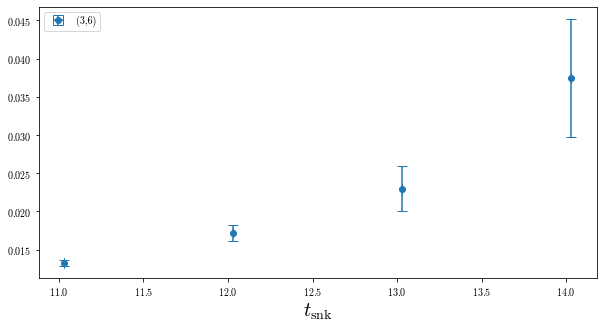

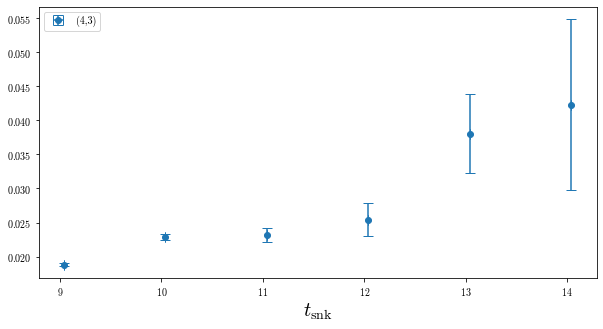

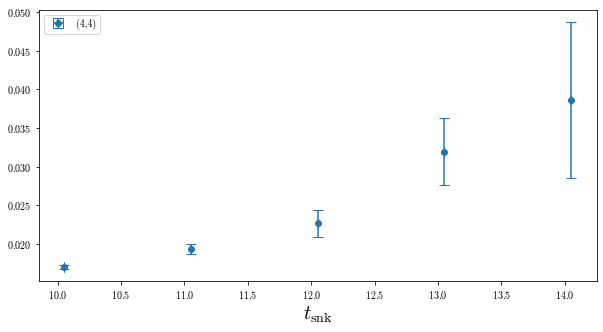

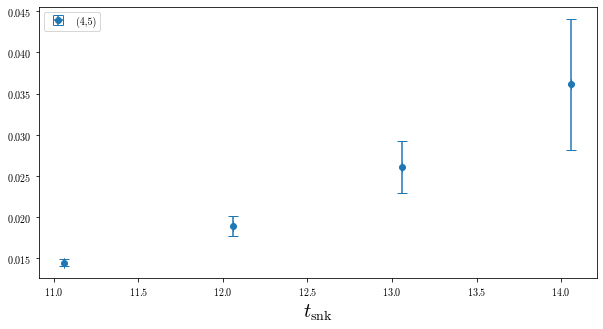

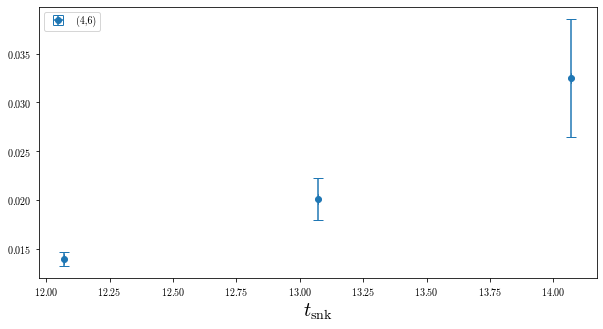

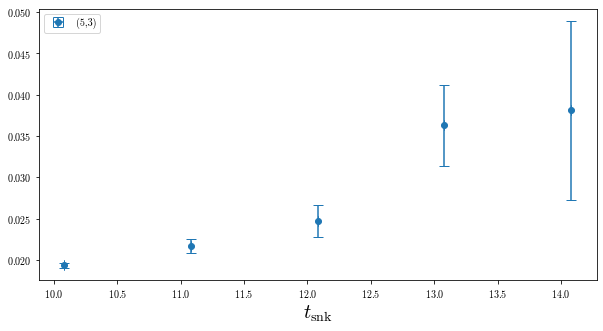

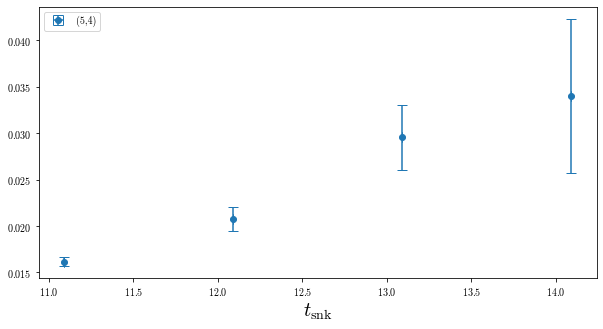

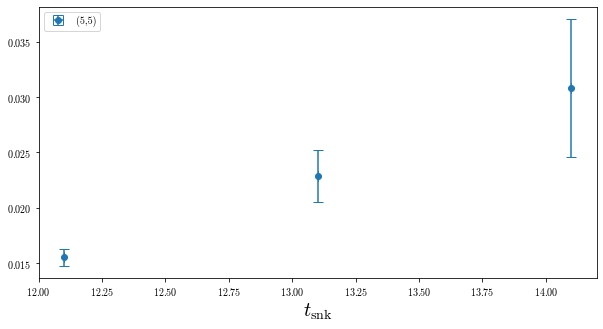

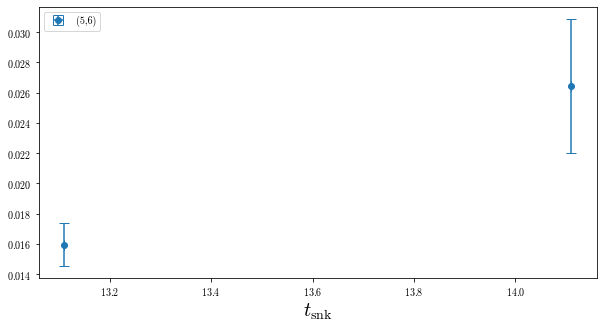

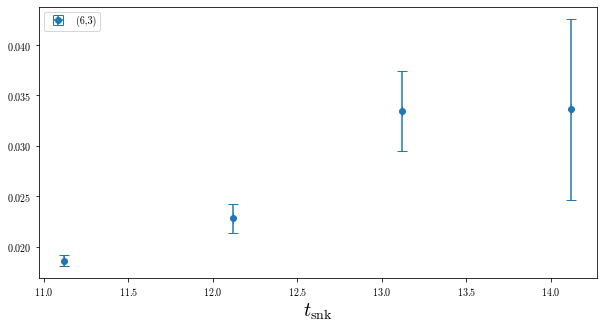

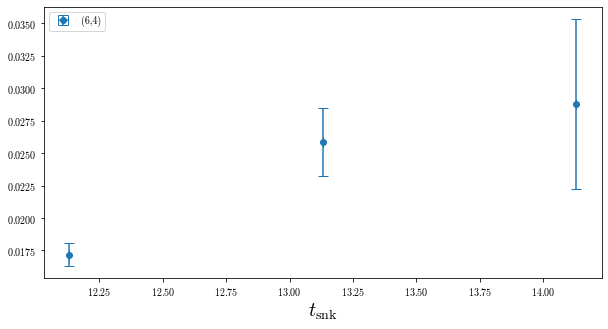

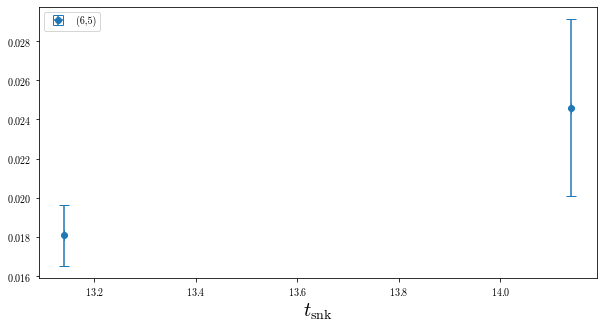

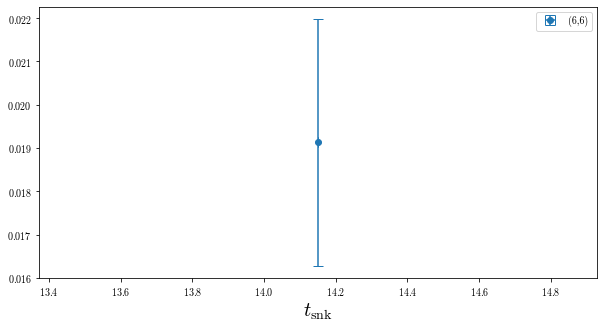

In [41]:
count = 0
for dsrc, dsnk in itertools.product([3,4,5,6], repeat=2):
    fig, ax = wplt.subplots(ncols=1, figsize=(10, 5))
    x = sumdata['tsnk'].values
    y = sumdata[f'{dsrc}:{dsnk}'].values
    y = (y[2:] - y[:-2])/2
    wplt.errorbar(ax, np.arange(len(y))+min(x)+count*0.01, y, fmt='o', capsize=5, label=f'({dsrc},{dsnk})')
    ax.set_xlabel(r'$t_\mathrm{snk}$', fontsize = 20)
    count += 1
    ax.legend()

In [42]:
def summation_model_single(x, p):
    # linear + exponential model. Note that p['B'] is the matrix element of interest.
    xx = x['tsnk'] - x['dsrc'] - x['dsnk']
    return p['A'] + p['B']*xx + p['C']*np.exp(-p['dE']*xx)

def summation_model_line(x, p):
    # linear model
    xx = x['tsnk'] - x['dsrc'] - x['dsnk']
    return p['A'] + p['B']*xx

def poly(x, p):
    return sum(pn*x**n for n, pn in enumerate(p))

def add_errs(arr, frac=0.1):
    tmp = []
    for elt in arr:
        if elt == 0:
            tmp.append(gv.gvar(0, 1))
        else:
            tmp.append(gv.gvar(elt, elt*frac))
    return np.array(tmp)

sumresults = []
for dsrc, dsnk in itertools.product([3, 4], repeat=2):
    df = sumdata[~sumdata[f'{dsrc}:{dsnk}'].isna()]
    for tmin in [0,1,2,3,]:#4,5,6]:
        for tmax in [None, -1, -2]:
            x = {'tsnk': df['tsnk'].values[tmin:tmax], 'dsrc': dsrc, 'dsnk': dsnk}
            y = df[f'{dsrc}:{dsnk}'].values[tmin:tmax]
            if len(y) > 4:

                ##############           
                # Full model #
                ##############
                prior = {
                    'A': gv.gvar(-0.15, 10.55),
                    'B': gv.gvar(0.025, 10.055),
                    'C': gv.gvar(1e-3, 1.0),
                    'log(dE)': np.log(gv.gvar(1.0, 0.75)),
                }
                fit = lsqfit.nonlinear_fit(data=(x, y), fcn=summation_model_single, prior=prior)
                weight = aic_model_probability(fit)
                ndata = len(y)
                nparams = 4
                p_value = stats.correlated_p(fit.chi2, ndata, nparams)
                sumresults.append({
                    'fit': fit,
                    'chi2/dof': fit.chi2/fit.dof,
                    'Q': fit.Q,
                    'A': fit.p['A'],
                    'B': fit.p['B'],
                    'C': fit.p['C'],
                    'dE': fit.p['dE'],
                    'tmin': tmin,
                    #'delta': dsrc,
                    'dsrc' : dsrc,
                    'dsnk' : dsnk,
                    'weight': weight,
                    'model': 'full',
                    'ndata': ndata,
                    'nparams': nparams,
                    'p_value': p_value,
                })

            if len(y) > 2:
                #############
                # Line only #
                #############
                prior = {
                    'A': gv.gvar(-0.15, 10.55),#-0.55),
                    'B': gv.gvar(0.025, 10.055),#0.055),
                }
                fit = lsqfit.nonlinear_fit(data=(x, y), fcn=summation_model_line, prior=prior)
                ndata = len(y)
                nparams = 2
                p_value = stats.correlated_p(fit.chi2, ndata, nparams)
                                
                weight = aic_model_probability(fit)
                sumresults.append({
                    'fit': fit,
                    'chi2/dof': fit.chi2/fit.dof,
                    'Q': fit.Q,
                    'A': fit.p['A'],
                    'B': fit.p['B'],
                    'C': np.nan,
                    'dE': np.nan,
                    'tmin': tmin,
                    'tmax': tmax,
                    'dsrc': dsrc,
                    'dsnk': dsnk,
                    'weight': weight,
                    'model': 'line',
                    'ndata': ndata,
                    'nparams': nparams,
                    'p_value': p_value,
                })

sumresults = pd.DataFrame(sumresults)
sumresults['weight'] = sumresults['weight']/sumresults['weight'].sum()

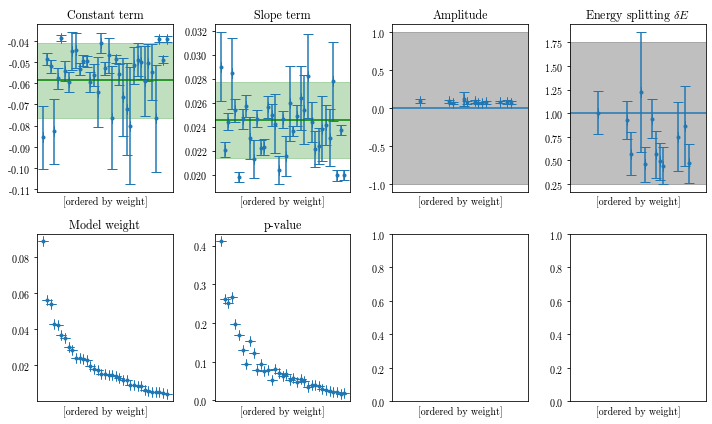

In [43]:
fig, axarr = wplt.subplots(ncols=4, nrows=2, figsize=(10, 6), sharex=True)

# cut is chi^2 / dof <= 2 and snr > 1.0
mask =\
    (sumresults['chi2/dof'] <= 2) &\
    (sumresults['B'].apply(analysis.n2s) < 1.0) &\
    ~((sumresults['tmin'] > 0) & (sumresults['model'] == 'full'))

df = sumresults[mask].sort_values(by=['weight'], ascending=False)

y = df['A'].values
x = np.arange(len(y))
wplt.errorbar(axarr[0,0], x, y, fmt='.', capsize=5)
# wplt.errorbar(axarr[1,0], x, analysis.n2s(y), fmt='.', capsize=5)
wplt.errorbar(axarr[1,0], x, df['weight'].values, fmt='.', capsize=5)
wplt.errorbar(axarr[1,1], x, df['p_value'].values, fmt='.', capsize=5)
# wplt.axhline(axarr[0], y=prior['A'], color='k')
wplt.axhline(axarr[0,0], stats.model_avg(y, df['weight'].values), color='g')

y = df['B'].values
x = np.arange(len(y))
wplt.errorbar(axarr[0,1], x, y, fmt='.', capsize=5)
# wplt.errorbar(axarr[1,1], x, analysis.n2s(y), fmt='.', capsize=5)
# wplt.axhline(axarr[1], y=prior['B'], color='k')
wplt.axhline(axarr[0,1], stats.model_avg(y, df['weight'].values), color='g')
# wplt.axhline(axarr[1,1], analysis.n2s(stats.model_avg(y, df['weight'].values)), color='g')

y = df['C'].values
x = np.arange(len(y))
wplt.errorbar(axarr[0,2], x, y, fmt='.', capsize=5)
# wplt.errorbar(axarr[1,2], x, analysis.n2s(y), fmt='.', capsize=5)
wplt.axhline(axarr[0,2], y=gv.gvar(1e-3, 1.0))
wplt.axhline(axarr[0,2], stats.model_avg(y, df['weight'].values), color='g')

y = df['dE'].values
x = np.arange(len(y))
wplt.errorbar(axarr[0,3], x, y, fmt='.', capsize=5)
# wplt.errorbar(axarr[1,3], x, analysis.n2s(y), fmt='.', capsize=5)
wplt.axhline(axarr[0,3], y=gv.gvar(1.0, 0.75))
wplt.axhline(axarr[0,3], stats.model_avg(y, df['weight'].values), color='g')

axarr[0,0].set_title("Constant term")
axarr[0,1].set_title("Slope term")
axarr[0,2].set_title("Amplitude")
axarr[0,3].set_title(r"Energy splitting $\delta E$")

axarr[1,0].set_title("Model weight")
axarr[1,1].set_title("p-value")

for ax in np.ravel(axarr):
    ax.set_xticks([])
    ax.set_xlabel("[ordered by weight]")


    fig.tight_layout()
fig.savefig(f'{out_dir}/summation_method_stab_plots.pdf')

In [44]:
tmp = stats.model_avg(df['B'].values, df['weight'].values)
print(f'Result for B: {tmp}')
for dsrc, dsnk in itertools.product([3, 4], repeat = 2):
    mask = (df['dsrc'] == dsrc) & (df['dsnk'] == dsnk)
    subdf = df[mask]
    B_tmp = stats.model_avg(subdf['B'].values, subdf['weight'].values)
    print(f'Result for B on ({dsrc}, {dsnk}) = {B_tmp}')

Result for B: 0.0245(32)
Result for B on (3, 3) = 0.0250(10)
Result for B on (3, 4) = 0.0228(21)
Result for B on (4, 3) = 0.0247(21)
Result for B on (4, 4) = 0.0256(47)


In [45]:
df    # accepted fits

,fit,chi2/dof,Q,A,B,C,dE,tmin,dsrc,dsnk,weight,model,ndata,nparams,p_value,tmax
80,Least Square Fit:\n chi2/dof [dof] = 0.44 [4]...,0.444602,0.776430,-0.086(15),0.0290(29),NaN,NaN,3,4,4,0.088909,line,4,2,0.410983,NaN
39,Least Square Fit:\n chi2/dof [dof] = 0.67 [4]...,0.670241,0.612550,-0.0486(27),0.02207(64),NaN,NaN,2,3,4,0.056618,line,4,2,0.261719,-2.0
60,Least Square Fit:\n chi2/dof [dof] = 0.69 [4]...,0.690232,0.598596,-0.0520(30),0.02440(72),NaN,NaN,2,4,3,0.054399,line,4,2,0.251462,-2.0
81,Least Square Fit:\n chi2/dof [dof] = 0.41 [3]...,0.408014,0.747244,-0.083(15),0.0284(30),NaN,NaN,3,4,4,0.043155,line,3,2,0.268569,-1.0
22,Least Square Fit:\n chi2/dof [dof] = 0.81 [4]...,0.813556,0.516217,-0.0577(48),0.02534(92),NaN,NaN,3,3,3,0.042508,line,4,2,0.196496,-2.0
75,Least Square Fit:\n chi2/dof [dof] = 0.89 [4]...,0.885142,0.471737,-0.0385(14),0.01981(44),NaN,NaN,1,4,4,0.036838,line,4,2,0.170285,-2.0
4,Least Square Fit:\n chi2/dof [dof] = 0.8 [7] ...,0.803218,0.584449,-0.0541(46),0.02462(83),0.096(22),1.01(22),0,3,3,0.035359,full,7,4,0.131491,NaN
19,Least Square Fit:\n chi2/dof [dof] = 1.3 [6] ...,1.323468,0.242472,-0.0596(47),0.02570(91),NaN,NaN,3,3,3,0.030157,line,6,2,0.093771,NaN
64,Least Square Fit:\n chi2/dof [dof] = 0.68 [3]...,0.682074,0.562869,-0.0448(90),0.0231(17),NaN,NaN,3,4,3,0.028608,line,3,2,0.152584,-2.0
43,Least Square Fit:\n chi2/dof [dof] = 0.8 [3] ...,0.797263,0.495165,-0.0444(81),0.0213(16),NaN,NaN,3,3,4,0.024069,line,3,2,0.121974,-2.0


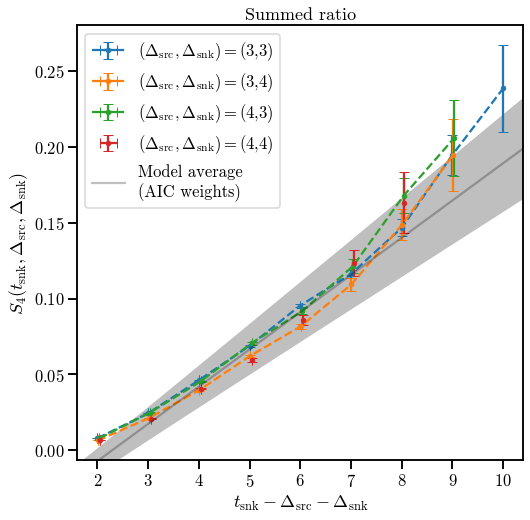

In [46]:
with sns.plotting_context("talk"):

    fig, ax = wplt.subplots(ncols=1, figsize=(8, 8))

    for idx, (dsrc, dsnk) in enumerate(itertools.product([3,4,5,6], repeat=2)):
        if (dsrc, dsnk) not in [(3,3), (3,4), (4,3), (4,4)]:
            continue
        offset = idx*0.01
        x = sumdata['tsnk'].values - dsrc - dsnk + offset
        y = sumdata[f'{dsrc}:{dsnk}'].values
        if (dsrc, dsnk) in [(3,3),(3,4),(4,3)]:
            fmt = '.--'
        else:
            fmt = '.'
        wplt.errorbar(ax, x, y, fmt=fmt, capsize=5,
                     label=r"$(\Delta_{\rm src}, \Delta_{\rm snk})=$"+f"({dsrc},{dsnk})")


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    mask =\
        (sumresults['chi2/dof'] <= 2) &\
        (sumresults['B'].apply(analysis.n2s) < 1.0) &\
        ~((sumresults['tmin'] > 0) & (sumresults['model'] == 'full'))

    df = sumresults[mask].sort_values(by=['weight'], ascending=False)
    slope = stats.model_avg(df['B'].values, df['weight'].values)

    mask = mask & (sumresults['dsrc'] == 3) & (sumresults['dsnk'] == 3)
    df = sumresults[mask]
    intercept = stats.model_avg(df['A'].values, df['weight'].values)

    x = np.linspace(1, 11)
    y = intercept + slope*x
    sum_ratio_fit_x = x
    sum_ratio_fit_y = y
    #print(y)
    wplt.errorbar(ax, x, y, color='k', bands=True, alpha=0.25,
                 label='Model average\n(AIC weights)')



    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.legend()
    ax.set_xlabel(r"$t_{\rm snk} - \Delta_{\rm src} - \Delta_{\rm snk}$")
    ax.set_ylabel(r"$S_4(t_{\rm snk}, \Delta_{\rm src}, \Delta_{\rm snk})$")
    ax.set_title("Summed ratio")

## Plot summed data for talk

In [48]:
style3 = copy(style)

# style3['markersize'] = 20
# style3['ebar_width'] = 3.0
# style3['endcaps'] = 5.0


style3['colwidth'] = 1400 / pts_per_inch
style3['textwidth'] = 1400 / pts_per_inch
style3['fontsize'] = 75
style3['tickwidth'] = 1.0
style3['ticklength'] = 6.0
style3['spinewidth'] = 1.0
style3['axeswidth'] = 1.0
style3['markersize'] = 30
style3['ebar_width'] = 5.0
style3['endcaps'] = 7.5

style3['linewidth'] = 3
style3['tick_fontsize'] = 45.0
style3['leg_fontsize'] = 35.0
style3['wfontsize'] = 200

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/summed_data_ALL.pdf.


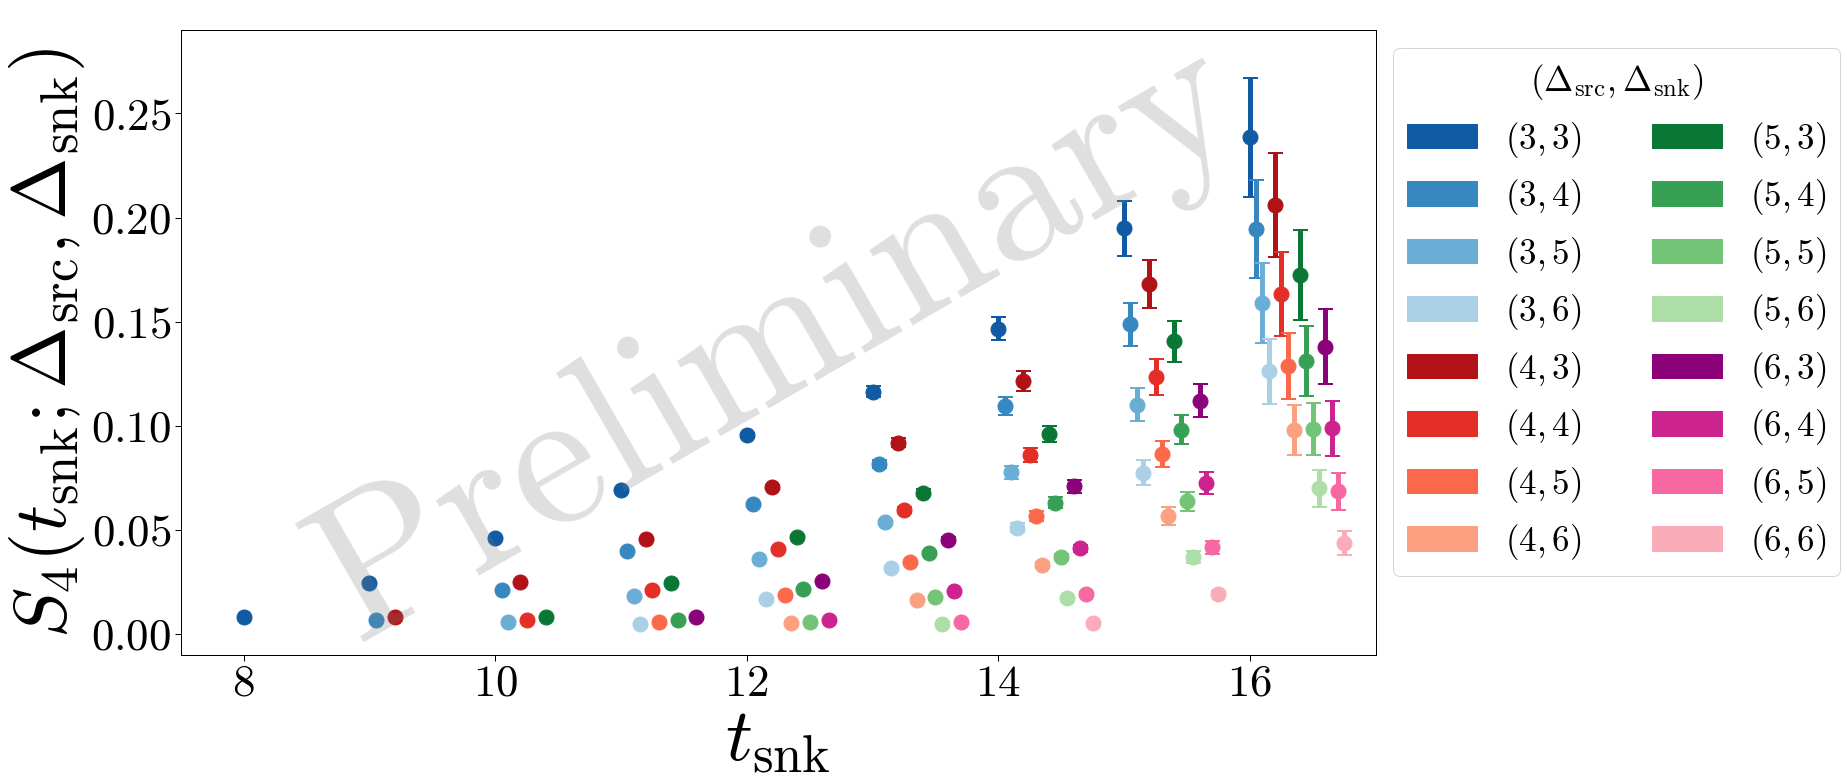

In [49]:
reload(pt)

colors = sns.color_palette('Blues', n_colors = 5)[1:][::-1] + sns.color_palette('Reds', n_colors = 5)[1:][::-1] + \
        sns.color_palette('Greens', n_colors = 5)[1:][::-1] + sns.color_palette('RdPu', n_colors = 5)[1:][::-1]

fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]
patches = []
offset = 0.05
for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    color = colors[idx]
    x = sumdata['tsnk'].values + offset * idx
    # x = sumdata['tsnk'].values + offset * idx - dsrc - dsnk
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

pt.add_watermark(ax0, style = style3)
ax0.set_xlabel(r'$t_\mathrm{snk}$')
# ax0.set_xlabel(r'$t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')

ax0.set_xlim((7.5, 17))
# ax0.set_xlim((1.5, 10.5))
ax0.set_ylim((-0.01, 0.29))

pt.stylize_axis(ax0, style = style3)
legend = plt.legend(title = r'$(\Delta_{\mathrm{src}}, \Delta_{\mathrm{snk}})$', handles = patches, \
           fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc, ncol = 2)
plt.setp(legend.get_title(), fontsize = style3['leg_fontsize'])

# path3 = f'{out_dir}/summed_data.pdf'
path3 = f'{out_dir}/summed_data_ALL.pdf'
pt.save_figure(path3)
print(f'Output saved to {path3}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/summed_data2.pdf.


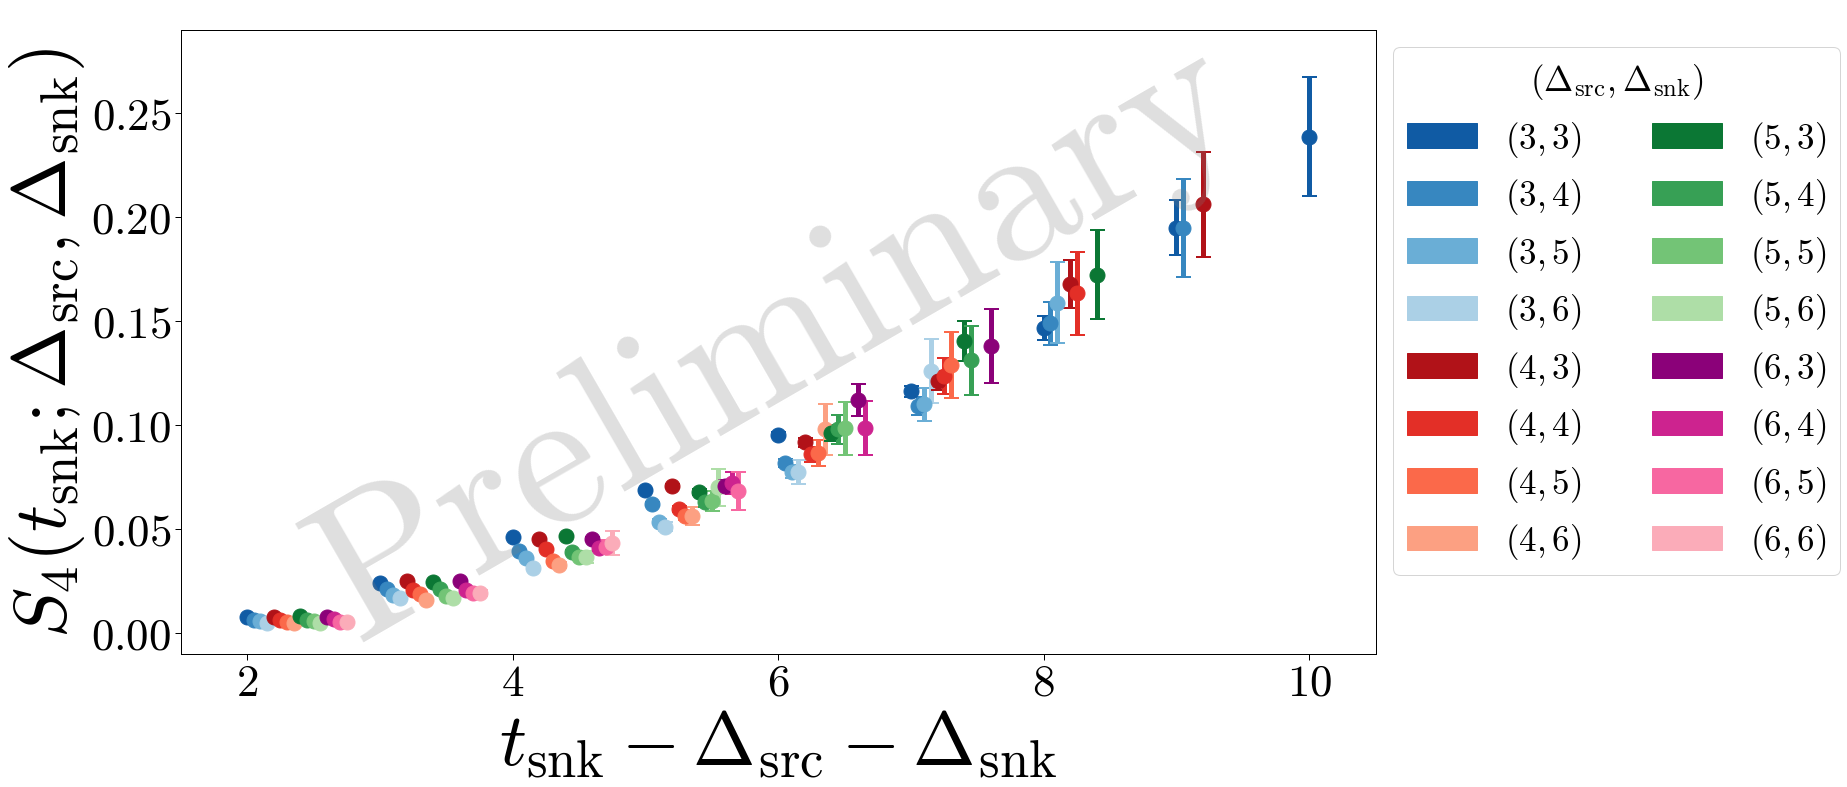

In [50]:
reload(pt)

fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]
patches = []
offset = 0.05
for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    color = colors[idx]
    # x = sumdata['tsnk'].values + offset * idx
    x = sumdata['tsnk'].values + offset * idx - dsrc - dsnk
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

pt.add_watermark(ax0, style = style3)
# ax0.set_xlabel(r'$t_\mathrm{snk}$')
ax0.set_xlabel(r'$t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')

# ax0.set_xlim((7.5, 17))
ax0.set_xlim((1.5, 10.5))
ax0.set_ylim((-0.01, 0.29))

pt.stylize_axis(ax0, style = style3)
legend = plt.legend(title = r'$(\Delta_{\mathrm{src}}, \Delta_{\mathrm{snk}})$', handles = patches, \
           fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc, ncol = 2)
plt.setp(legend.get_title(), fontsize = style3['leg_fontsize'])

# path3 = f'{out_dir}/summed_data.pdf'
path3 = f'{out_dir}/summed_data2.pdf'
pt.save_figure(path3)
print(f'Output saved to {path3}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/summed_data_for_fit2.pdf.


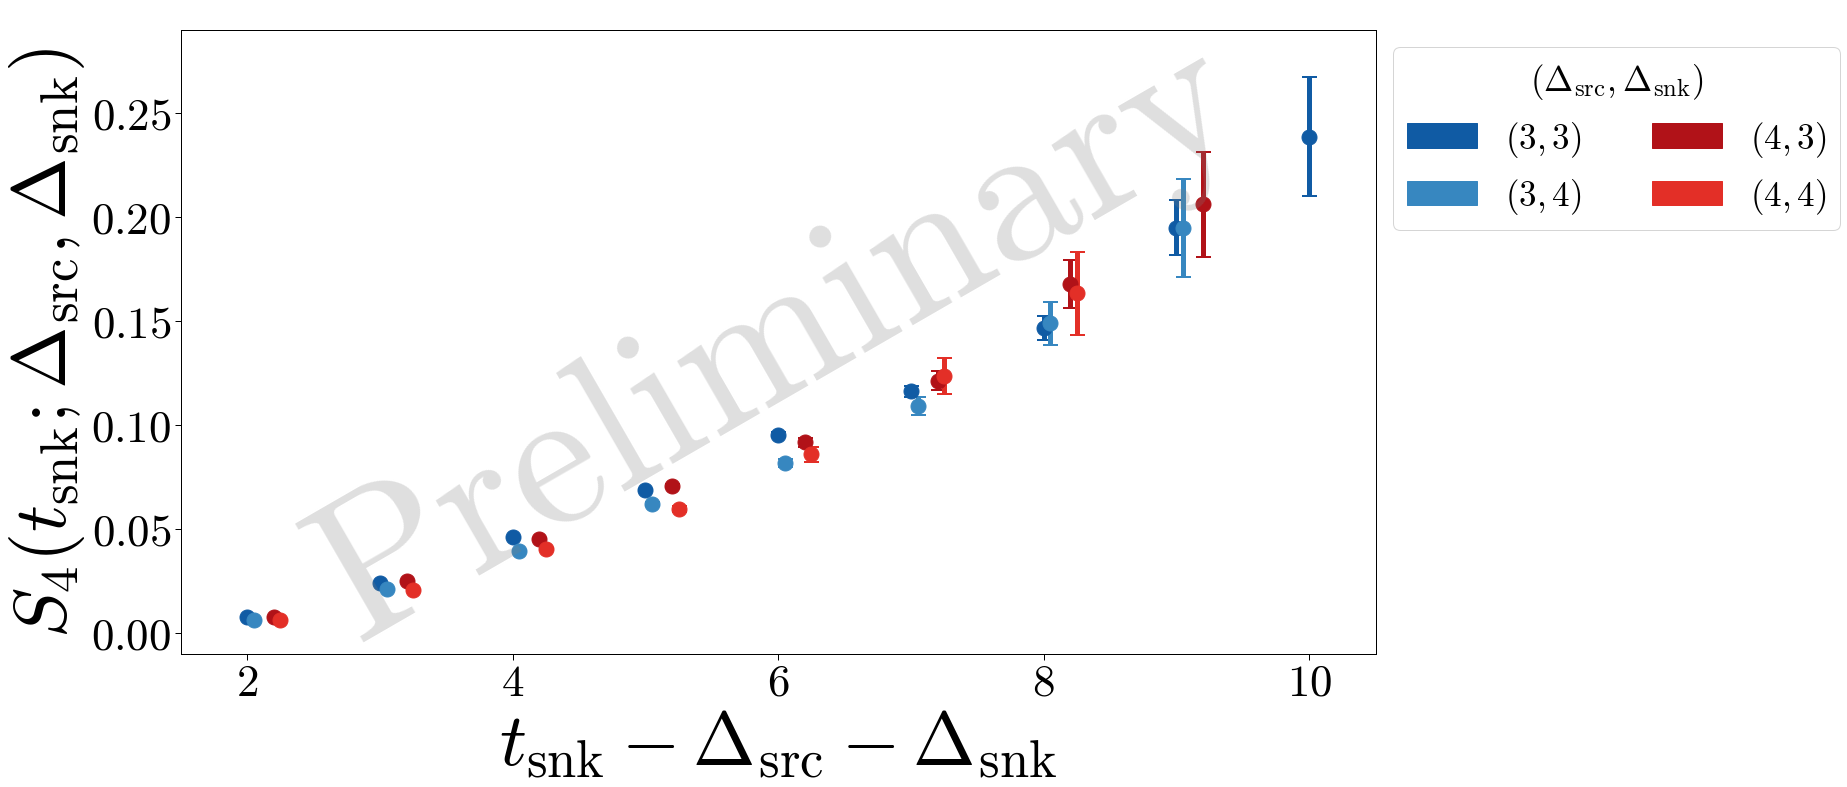

In [51]:
fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]
patches = []
offset = 0.05
# for (dsrc, dsnk), idx in zip([[3, 3], [4, 3], [3, 4], [4, 4], [5, 5], [6, 5], [5, 6], [6, 6], [5, 3], [3, 5], [5, 4], [4, 5], [6, 3], [3, 6], [6, 4], [4, 6]], range(len(colors))):
for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    if dsrc > 4 or dsnk > 4:
        continue
    color = colors[idx]
    # x = sumdata['tsnk'].values + offset * idx
    x = sumdata['tsnk'].values + offset * idx - dsrc - dsnk
    
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

pt.add_watermark(ax0, style = style3)

# ax0.set_xlabel(r'$t_\mathrm{snk}$')
ax0.set_xlabel(r'$t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')

ax0.set_xlim((1.5, 10.5))
# ax0.set_xlim((7.5, 17))
ax0.set_ylim((-0.01, 0.29))

pt.stylize_axis(ax0, style = style3)
legend = plt.legend(title = r'$(\Delta_{\mathrm{src}}, \Delta_{\mathrm{snk}})$', handles = patches, \
           fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc, ncol = 2)
plt.setp(legend.get_title(), fontsize = style3['leg_fontsize'])

# path4 = f'{out_dir}/summed_data_for_fit.pdf'
path4 = f'{out_dir}/summed_data_for_fit2.pdf'
pt.save_figure(path4)
print(f'Output saved to {path4}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/summed_data_for_fit3.pdf.


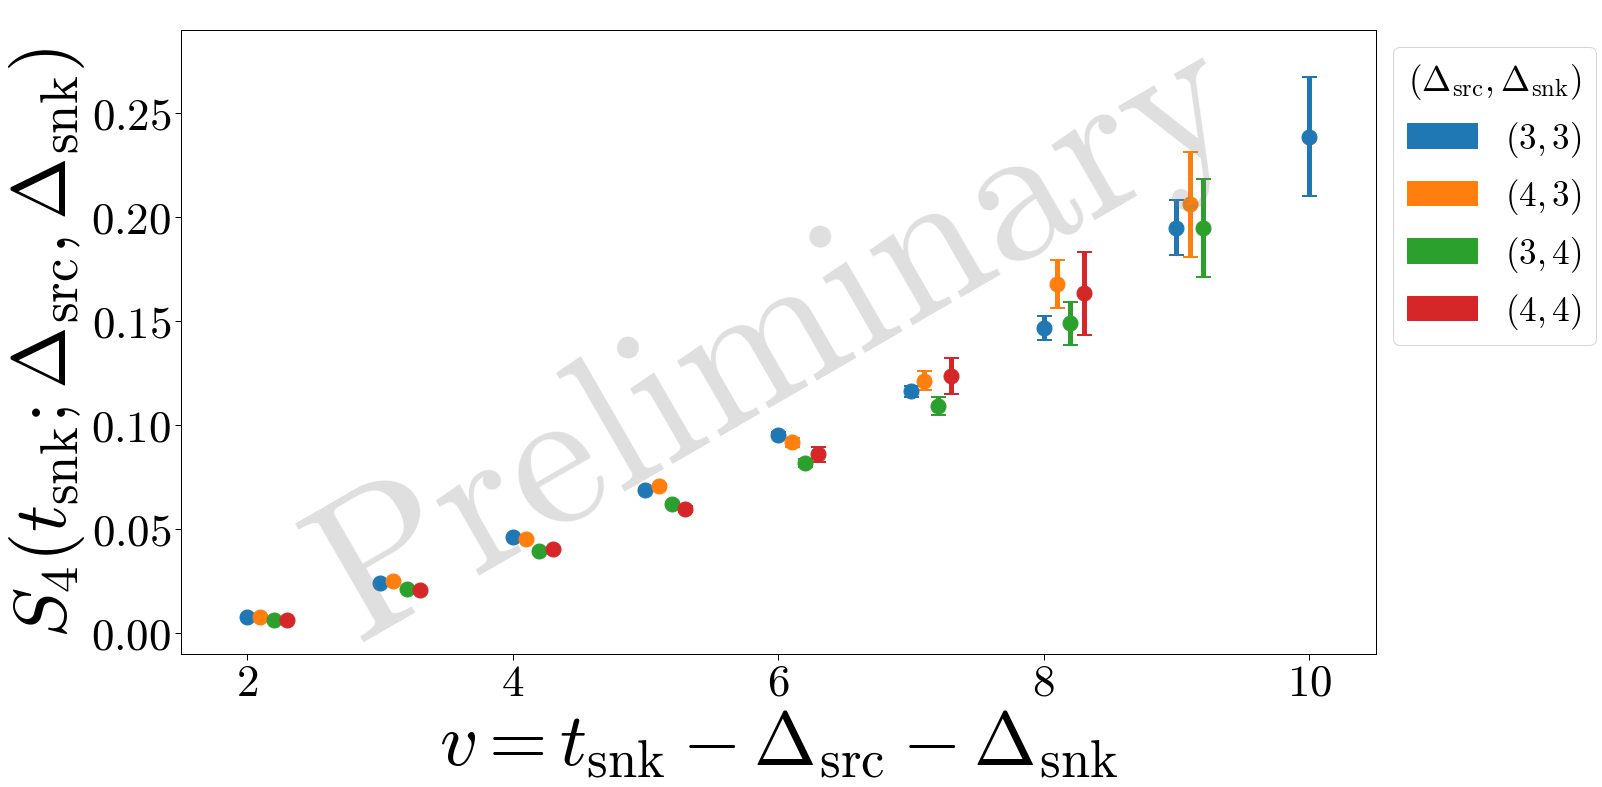

In [58]:
colors = sns.color_palette()[:4]
# colors = sns.color_palette()[1:5]

fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]
patches = []
offset = 0.1
# for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
for (dsrc, dsnk), idx in zip([[3, 3], [4, 3], [3, 4], [4, 4]], range(len(colors))):
    color = colors[idx]
    # x = sumdata['tsnk'].values + offset * idx
    x = sumdata['tsnk'].values + offset * idx - dsrc - dsnk
    
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

pt.add_watermark(ax0, style = style3)

# ax0.set_xlabel(r'$t_\mathrm{snk}$')
# ax0.set_xlabel(r'$t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_xlabel(r'$v = t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')

ax0.set_xlim((1.5, 10.5))
# ax0.set_xlim((7.5, 17))
ax0.set_ylim((-0.01, 0.29))

pt.stylize_axis(ax0, style = style3)
legend = plt.legend(title = r'$(\Delta_{\mathrm{src}}, \Delta_{\mathrm{snk}})$', handles = patches, \
           fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc)
#            fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc, ncol = 2)
plt.setp(legend.get_title(), fontsize = style3['leg_fontsize'])

# path4 = f'{out_dir}/summed_data_for_fit.pdf'
path4 = f'{out_dir}/summed_data_for_fit3.pdf'
pt.save_figure(path4)
print(f'Output saved to {path4}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/summed_data_fit_all3.pdf.


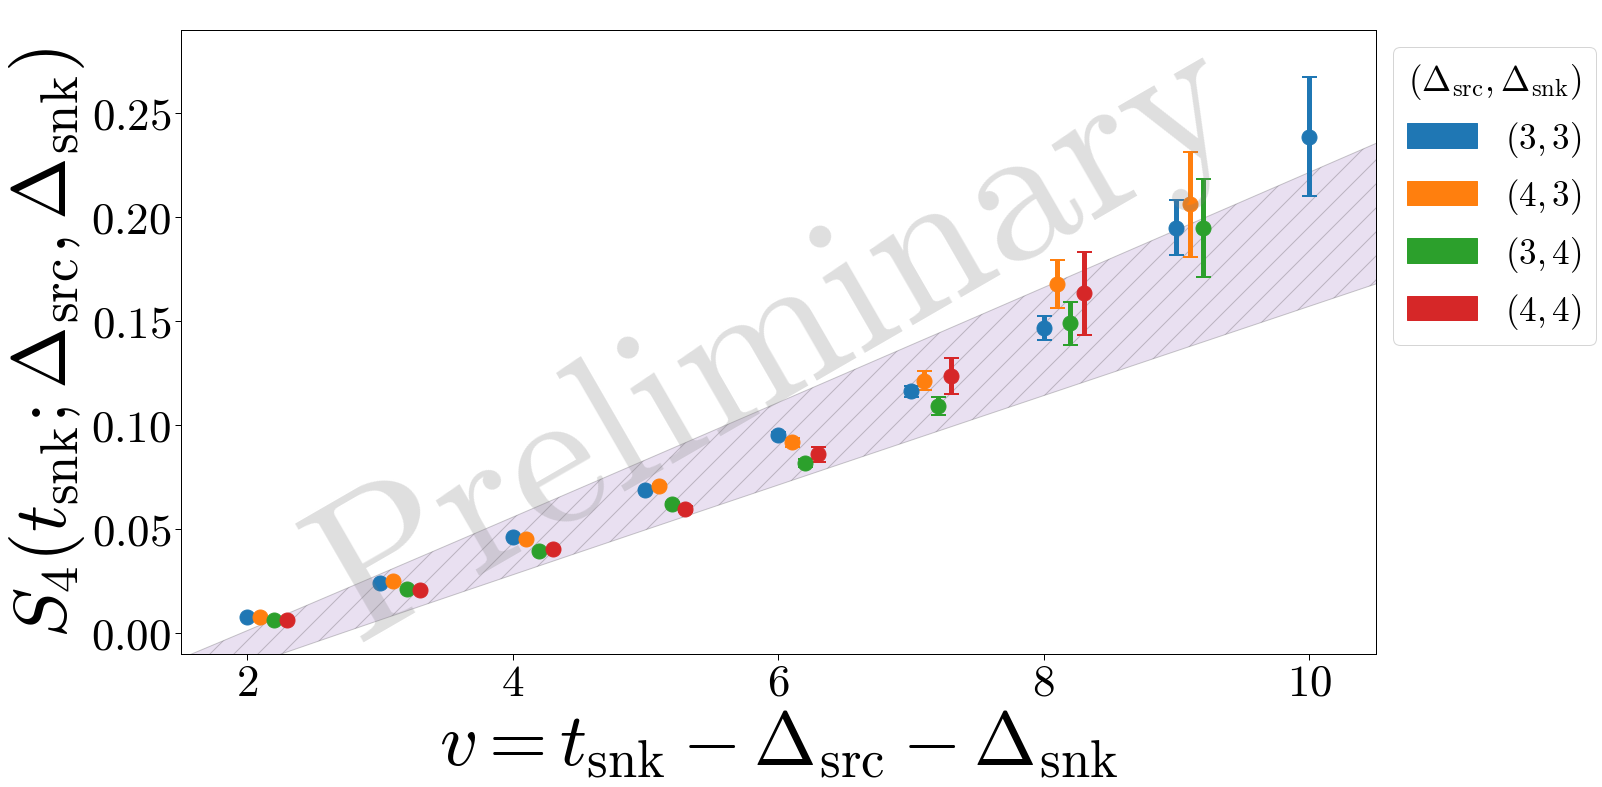

In [59]:
fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]
patches = []
offset = 0.1
for (dsrc, dsnk), idx in zip([[3, 3], [4, 3], [3, 4], [4, 4]], range(len(colors))):
    color = colors[idx]
    #x = sumdata['tsnk'].values
    x = sumdata['tsnk'].values - dsrc - dsnk + offset * idx
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        #mpatches.Patch(color = color, label = r'$(\Delta_\mathrm{src}, \Delta_\mathrm{snk}) = (' + str(dsrc) + r',' + str(dsnk) + r')$')
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

# sum_ratio_fit_x
# sum_ratio_fit_y
# ax0.fill_between(sum_ratio_fit_x, gv.mean(sum_ratio_fit_y) - gv.sdev(sum_ratio_fit_y), gv.mean(sum_ratio_fit_y) \
#                  + gv.sdev(sum_ratio_fit_y), color = 'grey', alpha = 0.2, hatch = '///', edgecolor = 'k')
# ax0.fill_between(sum_ratio_fit_x, gv.mean(sum_ratio_fit_y) - gv.sdev(sum_ratio_fit_y), gv.mean(sum_ratio_fit_y) \
#                  + gv.sdev(sum_ratio_fit_y), color = 'lemonchiffon', alpha = 0.4, hatch = '/', edgecolor = 'k')
ax0.fill_between(sum_ratio_fit_x, gv.mean(sum_ratio_fit_y) - gv.sdev(sum_ratio_fit_y), gv.mean(sum_ratio_fit_y) \
                 + gv.sdev(sum_ratio_fit_y), color = sns.color_palette()[4], alpha = 0.2, hatch = '/', edgecolor = 'k')
# patches.append(mpatches.Patch(color = 'grey', alpha = 0.2, hatch = '///', ec = 'k', label = 'Joint linear fit'))

pt.add_watermark(ax0, style = style3)

# ax0.set_xlabel(r'$t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_xlabel(r'$v = t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')
ax0.set_xlim((1.5, 10.5))
ax0.set_ylim((-0.01, 0.29))

pt.stylize_axis(ax0, style = style3)
legend = plt.legend(title = r'$(\Delta_{\mathrm{src}}, \Delta_{\mathrm{snk}})$', handles = patches, \
           fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc)
#            fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc, ncol = 2)
plt.setp(legend.get_title(), fontsize = style3['leg_fontsize'])

path4 = f'{out_dir}/summed_data_fit_all3.pdf'
pt.save_figure(path4)
print(f'Output saved to {path4}.')

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/summed_data_fit_all.pdf.


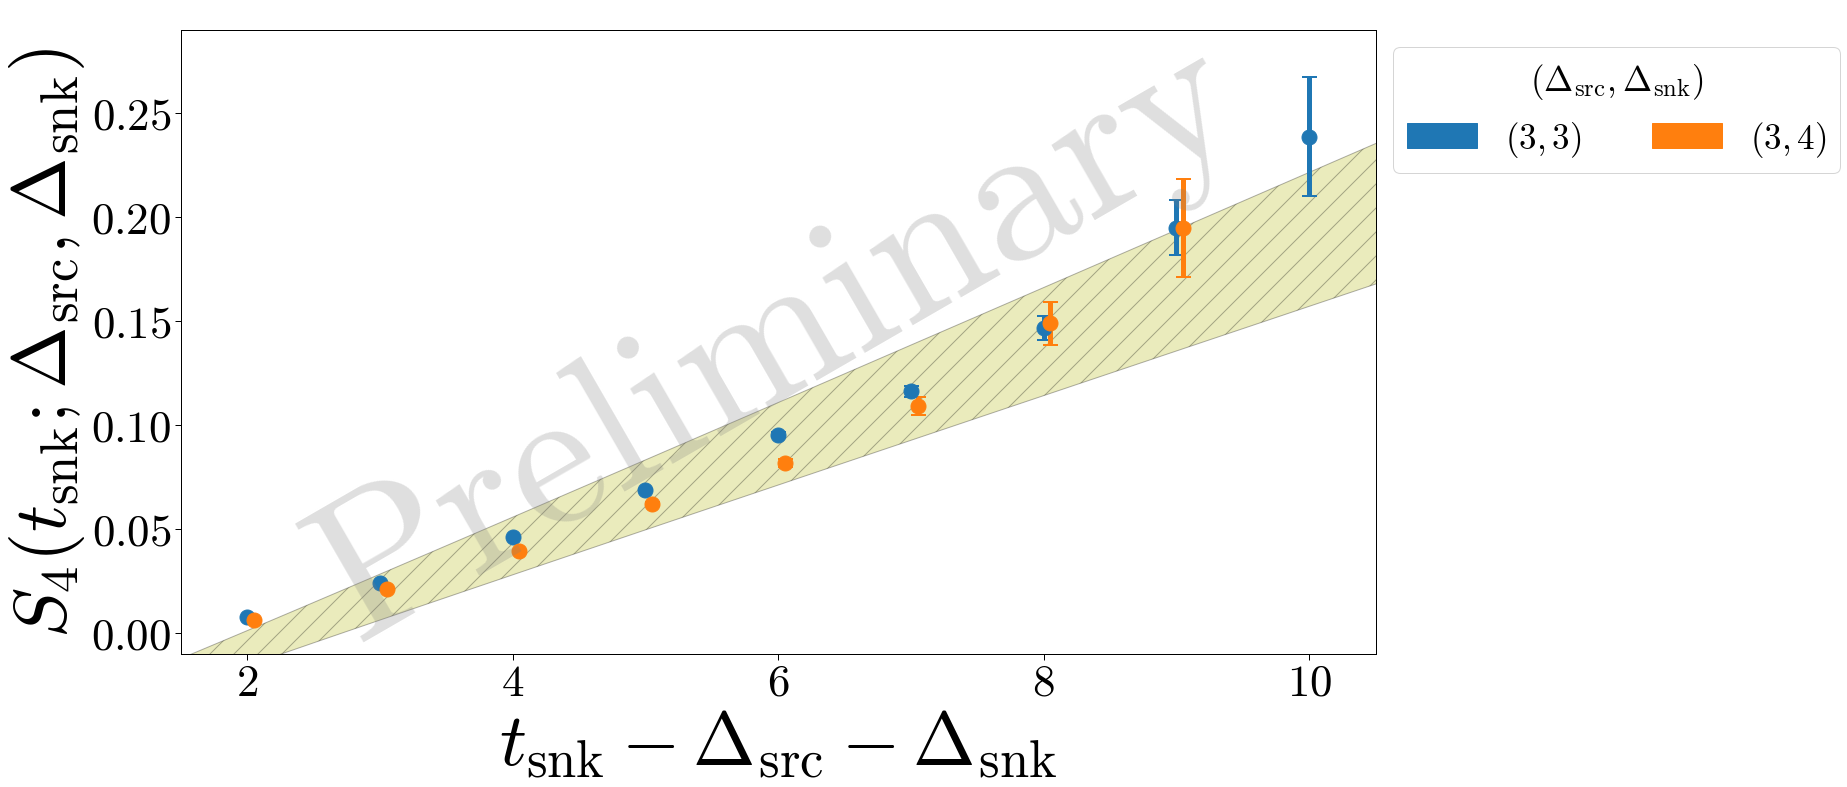

In [54]:
fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]
patches = []
offset = 0.05
# for (dsrc, dsnk), idx in zip([[3, 3], [4, 3], [3, 4], [4, 4], [5, 5], [6, 5], [5, 6], [6, 6], [5, 3], [3, 5], [5, 4], [4, 5], [6, 3], [3, 6], [6, 4], [4, 6]], range(len(colors))):
for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    if dsrc > 4 or dsnk > 4:
        continue
    color = colors[idx]
    #x = sumdata['tsnk'].values
    x = sumdata['tsnk'].values - dsrc - dsnk + offset * idx
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        #mpatches.Patch(color = color, label = r'$(\Delta_\mathrm{src}, \Delta_\mathrm{snk}) = (' + str(dsrc) + r',' + str(dsnk) + r')$')
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

# sum_ratio_fit_x
# sum_ratio_fit_y
# ax0.fill_between(sum_ratio_fit_x, gv.mean(sum_ratio_fit_y) - gv.sdev(sum_ratio_fit_y), gv.mean(sum_ratio_fit_y) \
#                  + gv.sdev(sum_ratio_fit_y), color = 'grey', alpha = 0.2, hatch = '///', edgecolor = 'k')
# ax0.fill_between(sum_ratio_fit_x, gv.mean(sum_ratio_fit_y) - gv.sdev(sum_ratio_fit_y), gv.mean(sum_ratio_fit_y) \
#                  + gv.sdev(sum_ratio_fit_y), color = 'lemonchiffon', alpha = 0.4, hatch = '/', edgecolor = 'k')
ax0.fill_between(sum_ratio_fit_x, gv.mean(sum_ratio_fit_y) - gv.sdev(sum_ratio_fit_y), gv.mean(sum_ratio_fit_y) \
                 + gv.sdev(sum_ratio_fit_y), color = sns.color_palette()[8], alpha = 0.3, hatch = '/', edgecolor = 'k')
# patches.append(mpatches.Patch(color = 'grey', alpha = 0.2, hatch = '///', ec = 'k', label = 'Joint linear fit'))

pt.add_watermark(ax0, style = style3)

ax0.set_xlabel(r'$t_\mathrm{snk} - \Delta_\mathrm{src} - \Delta_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')
ax0.set_xlim((1.5, 10.5))
ax0.set_ylim((-0.01, 0.29))

pt.stylize_axis(ax0, style = style3)
legend = plt.legend(title = r'$(\Delta_{\mathrm{src}}, \Delta_{\mathrm{snk}})$', handles = patches, \
           fontsize = style3['leg_fontsize'], bbox_to_anchor = leg_loc, ncol = 2)
plt.setp(legend.get_title(), fontsize = style3['leg_fontsize'])

path4 = f'{out_dir}/summed_data_fit_all.pdf'
pt.save_figure(path4)
print(f'Output saved to {path4}.')

In [55]:
def full_model_avg_posterior_alldata(acc_fits_df):
    """Returns a function that gives the full model average over the accepted fits."""
    mask = ((acc_fits_df['dsrc'] == 3) | (acc_fits_df['dsrc'] == 4)) \
            & ((acc_fits_df['dsnk'] == 3) | (acc_fits_df['dsnk'] == 4))
    subdf = acc_fits_df[mask]
    subdf['weight'] = subdf['weight'] / np.sum(subdf['weight'])
    def model_avg(t):
        # Function to plot against the thing we're fitting
        posterior = []
        for idx, row in subdf.iterrows():
            dsrc, dsnk = row['dsrc'], row['dsnk']
            if row['model'] == 'line':
                m = summation_model_line
            else:
                m = summation_model_single
            tmp = m({'tsnk' : t, 'dsrc' : dsrc, 'dsnk' : dsnk}, row)
            posterior.append(tmp)
        posterior = np.array(posterior)
        weighted_avg = []
        for idx in range(len(t)):
            weighted_avg.append(
                stats.model_avg(posterior[:, idx], subdf['weight'])
            )
        return np.array(weighted_avg)
    return model_avg

def full_model_avg_posterior(acc_fits_df, dsrc, dsnk):
    """Returns a function that gives the full model average over the accepted fits."""
    mask = (acc_fits_df['dsrc'] == dsrc) & (acc_fits_df['dsnk'] == dsnk)
    subdf = acc_fits_df[mask]
    subdf['weight'] = subdf['weight'] / np.sum(subdf['weight'])
    def model_avg(t):
        # Function to plot against the thing we're fitting
        posterior = []
        for idx, row in subdf.iterrows():
            if row['model'] == 'line':
                m = summation_model_line
            else:
                m = summation_model_single
            tmp = m({'tsnk' : t, 'dsrc' : dsrc, 'dsnk' : dsnk}, row)
            posterior.append(tmp)
        posterior = np.array(posterior)
        weighted_avg = []
        for idx in range(len(t)):
            weighted_avg.append(
                stats.model_avg(posterior[:, idx], subdf['weight'])
            )
        return np.array(weighted_avg)
    return model_avg

def lin_model_avg_posterior(acc_fits_df, dsrc, dsnk):
    """Returns a function that gives the model average over the accepted fits."""
    mask = (acc_fits_df['dsrc'] == dsrc) & (acc_fits_df['dsnk'] == dsnk)
    subdf = acc_fits_df[mask]
    subdf['weight'] = subdf['weight'] / np.sum(subdf['weight'])
    def model_avg(t):
        # Function to plot against the thing we're fitting
        posterior = []
        for idx, row in subdf.iterrows():
            tmp = summation_model_line({'tsnk' : t, 'dsrc' : dsrc, 'dsnk' : dsnk}, row)
            posterior.append(tmp)
        posterior = np.array(posterior)
        weighted_avg = []
        for idx in range(len(t)):
            weighted_avg.append(
                stats.model_avg(posterior[:, idx], subdf['weight'])
            )
        return np.array(weighted_avg)
    return model_avg

In [ ]:
# Example model average (don't save)
fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]

dsrc = 3
dsnk = 3

idx = 0
color = colors[0]
#x = sumdata['tsnk'].values
x = sumdata['tsnk'].values + offset * idx
y = sumdata[f'{dsrc}:{dsnk}'].values
cvs = gv.mean(y)
stds = gv.sdev(y)
pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

averager = full_model_avg_posterior(df, 3, 3)
# averager = lin_model_avg_posterior(df, 3, 3)
xx = np.linspace(8, 16, 100)
yy = averager(xx)
# ax0.fill_between(xx, gv.mean(yy) - gv.sdev(yy), gv.mean(yy) + gv.sdev(yy), color = 'r', alpha = 0.2)

ex_fit = df.loc[4]
yyy = summation_model_single({'tsnk' : xx, 'dsrc' : 3, 'dsnk' : 3}, ex_fit)
ax0.fill_between(xx, gv.mean(yyy) - gv.sdev(yyy), gv.mean(yyy) + gv.sdev(yyy), color = 'g', alpha = 0.2)

ax0.set_xlabel(r'$t_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')
ax0.set_xlim((7.5, 17))
ax0.set_ylim((-0.01, 0.29))

In [ ]:
# Model average for all Delta_src, Delta_snk
fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]

for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    if dsrc > 4 or dsnk > 4:
        continue
    color = colors[idx]
    x = sumdata['tsnk'].values + offset * idx
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )

    averager = full_model_avg_posterior(df, dsrc, dsnk)
    xx = np.linspace(8, 16, 100) + offset * idx
    yy = averager(xx)
    ax0.fill_between(xx, gv.mean(yy) - gv.sdev(yy), gv.mean(yy) + gv.sdev(yy), color = color, alpha = 0.5, hatch = '///', edgecolor = 'k')
    
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

    ax0.set_xlabel(r'$t_\mathrm{snk}$')
    ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')
    ax0.set_xlim((7.5, 17))
    ax0.set_ylim((-0.01, 0.29))

In [ ]:
# Model average for all Delta_src, Delta_snk
fig, axes = pt.add_subplots(style = style3)
ax0 = axes[0]

for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    if dsrc > 4 or dsnk > 4:
        continue
    color = colors[idx]
    x = sumdata['tsnk'].values + offset * idx
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )
    
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style3)

averager = full_model_avg_posterior_alldata(df)
xx = np.linspace(6, 16, 100) + offset * idx
yy = averager(xx)
ax0.fill_between(xx, gv.mean(yy) - gv.sdev(yy), gv.mean(yy) + gv.sdev(yy), color = 'grey', alpha = 0.3, hatch = '///', edgecolor = 'k')

ax0.set_xlabel(r'$t_\mathrm{snk}$')
ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; \Delta_\mathrm{src}, \Delta_\mathrm{snk})$')
ax0.set_xlim((7.5, 17))
ax0.set_ylim((-0.01, 0.29))

In [ ]:
style

In [ ]:
style5 = copy(style)
style5['colwidth'] = 600 / pts_per_inch
style5['markersize'] = 20
style5['ebar_width'] = 3.0
style5['endcaps'] = 3.0
style5['asp_ratio'] = 16/9
style5['fontsize'] = 30.0

In [ ]:
# Save as separate plots
yrg = [(-0.02, 0.29), (-0.07, 0.24), (-0.07, 0.24), (-0.12, 0.22)]
other_idx = 0
for (dsrc, dsnk), idx in zip(itertools.product([3,4,5,6], repeat = 2), range(len(colors))):
    if dsrc > 4 or dsnk > 4:
        continue
    fig, axes = pt.add_subplots(style = style5)
    ax0 = axes[0]
    color = colors[idx]
    x = sumdata['tsnk'].values
    y = sumdata[f'{dsrc}:{dsnk}'].values
    cvs = gv.mean(y)
    stds = gv.sdev(y)
    patches.append( 
        mpatches.Patch(color = color, label = r'$(' + str(dsrc) + r',' + str(dsnk) + r')$')
    )

    #averager = full_model_avg_posterior(df, dsrc, dsnk)
    averager = lin_model_avg_posterior(df, dsrc, dsnk)
    xx = np.linspace(7, 17, 100)
    yy = averager(xx)
    ax0.fill_between(xx, gv.mean(yy) - gv.sdev(yy), gv.mean(yy) + gv.sdev(yy), color = 'k', alpha = 0.3, hatch = '///', edgecolor = 'k')
    
    pt.errorbar_1d(x, cvs, stds, ax = ax0, col = color, style = style5)

    ax0.set_xlabel(r'$t_\mathrm{snk}$')
    ax0.set_ylabel(r'$S_4(t_\mathrm{snk}; ' + str(dsrc) + r', ' + str(dsnk) + r')$')
    
    ax0.set_xticks([8, 10, 12, 14, 16])
    ax0.set_xticklabels(['8', '10', '12', '14', '16'])
    #ax0.set_yticks([-0.1, -0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25])
    #ax0.set_yticklabels(['-0.1', '-0.05', '0', '0.05', '0.1', '0.15', '0.2', '0.25'])
    ax0.set_yticks([-0.1, 0.0, 0.1, 0.2])
    ax0.set_yticklabels(['-0.1', '0', '0.1', '0.2'])

    ax0.set_xlim((7.5, 17))
    ax0.set_ylim(yrg[other_idx])
    
    #path = f'{out_dir}/summed_data_fit{dsrc}{dsnk}.pdf'
    #pt.save_figure(path)
    #print(f'Output saved to {path}.')
    
    other_idx += 1